# Conditioning Damped Sinusoids

This notebook is for studies of data conditioning effects for damped sinusoid models, with application to BH ringdown.

Topics include:

* Length of data segment
    - Affects Frequency bin widths, resolution of spikes.
* Sample rate
    - Biases, what method of downsampling is best?
* High and low-pass filtering
    - Dips at low and high frequecies. Digital filter vs. analogue i.e. butterworth. Biases.
* TGR
    - Biases when downsampling
    
Noise generation method: https://gist.github.com/maxisi/7d63b4878a48e5e1c5e0307159bb3e09

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import ringdown
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.patheffects as patheff
from matplotlib.collections import PatchCollection
from matplotlib.legend_handler import HandlerBase
import seaborn as sns
import pandas as pd
import tqdm
import multiprocessing
import arviz as az
import os
from matplotlib.gridspec import GridSpec as gs
import scipy
import random
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from brokenaxes import brokenaxes
#from sklearn.neighbors import KernelDensity

#Jupyter notebook imports:
sns.set_context('notebook')
sns.set_palette('colorblind')

rng_seed = 3 # 3 is a lucky number
rng = np.random.default_rng(rng_seed) # initialize random seed for all random dists

In [3]:
lalxtra_dir = "/mnt/ceph/users/misi/lscsoft/src/lalsuite-extra/data/lalsimulation" #location of lalsuite-extra, to use NRSur7dq4
db_dir = "/mnt/home/hsiegel/ceph/database_rd/" #absolute path of top level dir for database
os.environ["LAL_DATA_PATH"] = lalxtra_dir
import lal
import lalsimulation as ls
from lalsimulation.nrfits import eval_nrfit

In [4]:
import sys
sys.path.append('/mnt/home/hsiegel/ceph/LineCleaner')
from line_cleaner import clean_strain

In [5]:
def generate_noise(dur=128, sr=2**14, scale=1.5e-45, spike_amp = None, spike_mean = None, spike_std = None, rtrn_psd = False, lalpsd = False,lorentzian = True):
    #Generate noise for a given length of time and sample rate
    #dur: float, length of time to generate noise for
    #sr: float, sample rate
    #scale: float, magnitude of PSD
    #lalpsd: bool, if False then generate white noise / white noise with spike, if True then generate LIGO PSD / with spike
    #lorentzian: bool, if True then add Lorentzian when adding spike, else add Gaussian
    
    N = int(dur * sr)
    delta_t = 1/sr
    freqs = np.fft.rfftfreq(N, delta_t)
    delta_f = freqs[1] - freqs[0]
    times = np.arange(0 , dur, delta_t)
    
    if lalpsd:
        psd = []
        for x in freqs:
            psd.append( ls.SimNoisePSDaLIGOZeroDetHighPower(x))
        if np.isnan(psd[0]):
            psd[0] = psd[1]

    else:
        psd = np.ones(len(freqs))*scale
    
    if (spike_amp is not None and spike_mean is not None and spike_std is not None):
        if lorentzian:
            psd += spike_amp*spike_std/((2*np.pi)*((freqs-spike_mean)**2+(spike_std**2)/4)) #Lorentzian spike
            print("Adding Lorentzian spike to PSD")
        else:
            psd += spike_amp*np.exp(-0.5*((freqs-spike_mean)/spike_std)**2) #Gaussian spike
            print("Adding Gaussian spike to PSD")
    
    var = psd / (4.*delta_f)
    noise_real = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_imag = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_fd = noise_real + 1j*noise_imag
    
    noise_td = ringdown.TimeSeries(np.fft.irfft(noise_fd) / delta_t,times)
    psd = ringdown.PowerSpectrum(psd, freqs)
    
    if rtrn_psd:
        return noise_td, psd
    
    else:
        return noise_td

In [6]:
def np2(x): #Get next power of two
    p = 1
    while p <= x:
        p = p << 1
    return p

In [7]:
def damped_sinusoid(A,f,gamma,phase,times,verbose = False, reflect = True):
    #Create a time series for a damped sinusoid.
    #A: float, amplitude
    #f: float, central frequency
    #gamma: float, damping rate
    #phase: float, 0 to 2pi, phase of sinusoid
    #times: array, list of times to calculate damped sinusoid for, starting from peak of signal
    #verbose: bool, if True then print time series of damped sinusoid
    #reflect: bool, if True then reflect damped sinusoid at early times to make a "ring-up"
    
    t0 = times[0]
    times_input = times-t0 # rescale times for damped sinusoid functional input
    sin_func = A*np.cos(2*np.pi*f*times_input+phase)*np.exp(-gamma*times_input)
    if reflect:
        times = np.append(times-times_input[-1]-times_input[1],times)
        times_input = np.append(times_input-times_input[-1]-times_input[1],times_input)
        sin_func = A*np.cos(2*np.pi*f*times_input+phase)*np.exp(-gamma*abs(times_input))
    
    damped_sin = ringdown.TimeSeries(sin_func,times)
    
    if verbose:
        print(damped_sin)
        
    return damped_sin

# Downsampling 1 mode

In [8]:
sample_rate = 2**14
duration = 4096
noise_td, psd = generate_noise(lalpsd = True, rtrn_psd = True, dur=duration)
t0 = noise_td.index[-1]/2

times = noise_td.index
t0 = duration/2

In [9]:
#config_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/injection_configs/downsampling_studies/digital_filter"
results_dict = {}
dig_filt = True #Bool

for ds in [1,2,4,8,16]:
    fit = ringdown.Fit.from_config("/mnt/home/hsiegel/ceph/conditioning_data_studies/injection_configs/downsampling_studies/1mode_g150914_ds1.ini")
    
    nperseg = np2(16*fit.duration*(sample_rate)/ds)
    flow = max(10,1/fit.duration)
    fit.condition_data(f_min=flow,ds=ds,digital_filter=dig_filt)
    
    #hacky, fit that gets run from
    fit2 = ringdown.Fit(modes=fit.modes)
    fit2.data = fit.data
    fit2.set_target(t0=fit.t0,ra=fit.target.ra,dec=fit.target.dec,psi=fit.target.psi,duration=fit.duration)
    
    #design PSD acfs
    fit3 = ringdown.Fit(modes=fit.modes)
    fit3.set_target(t0=t0,duration = fit.duration)
    fit3.add_data(noise_td)
    fit3.condition_data(f_min=flow,ds=ds,digital_filter=dig_filt)
    fit3.compute_acfs(method='fd', nperseg=nperseg, f_min = flow) # flattened PSD
    for ifo in fit2.ifos:
        print(ifo)
        fit2.acfs[ifo] = fit3.acfs[None]

    A = fit.info['injection']['a']
    m = fit.info['injection']['m']
    chi = fit.info['injection']['chi'] 
    fit2.update_model(a_scale_max=10*max(A), m_min=m/2, m_max=m*2, chi_max=0.95, marginalized = True, flat_amplitude_prior = False)
    
    fit2.run(validation_enabled=False, prior=False)
    results_dict[str(ds)] = fit2

/mnt/home/hsiegel/ringdown/ringdown/fit.py:384: UserWarning: 'a_scale' depreacted, replacing with a_scale_max
  warnings.warn(f"'{k}' depreacted, replacing with {new}")
/mnt/home/hsiegel/ringdown/ringdown/fit.py:384: UserWarning: 'flat_a' depreacted, replacing with flat_amplitude_prior
  warnings.warn(f"'{k}' depreacted, replacing with {new}")


H1
L1


sample: 100%|██████████| 2000/2000 [00:28<00:00, 70.42it/s, 7 steps of size 6.49e-01. acc. prob=0.92] 


In [ ]:
for k,v in results_dict.items():
    if type(k) is str:
        print(k)
        name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW150914_NOnoise_SNR113_LIGODesignPSD_DigitalFilter_1mode_ds{k}_dur{d}s_cosinorestrict_phi5p34.nc".format(
            k=k,d=str(v.duration).replace(".","p"))
        print(name_str)
        v.result.to_netcdf(name_str)

# GW190521-like signal, different duration

## Spike

In [253]:
sample_rate = 2**12
duration = 4096

#signal parameters
f_qnm = 67.489
A = 1.2e-21
tau_qnm = 0.0155
phase_qnm = 5.34 # radians

# PSD parameters
spike_std = 0.05
spike_mean = f_qnm
spike_amp = 1.5e-45

noise_td, psd_analysis = generate_noise(sr=sample_rate, rtrn_psd=True, lalpsd = True, dur=duration,
                                            spike_mean=spike_mean, spike_std=spike_std, spike_amp = spike_amp)
times = noise_td.index

signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

t0 = duration/2

Adding Lorentzian spike to PSD


In [255]:
fit_dict_fundamental = {}
ds = 1

for dur in [0.05,0.1,0.2]:
    flow = max(1/dur, 10)
    fit = ringdown.Fit(modes=[(1, -2, 2, 2, 0)])
    fit.set_target(t0, duration=dur)
    fit.add_data(signal)
    fit.update_prior(a_scale_max=10*A, m_min=250/2, m_max=250*2)
    fit.condition_data(f_min=flow,ds=ds,digital_filter=True)
    nperseg = np2(16*fit.duration*(sample_rate)/ds)
    
    fit2 = ringdown.Fit(modes=[(1, -2, 2, 2, 0)])
    fit2.set_target(t0, duration=dur)
    fit2.add_data(signal+noise_td)
    fit2.condition_data(f_min=flow,ds=ds,digital_filter=True)
    fit2.compute_acfs(method='fd', nperseg=nperseg, f_min = flow) # flattened PSD

    fit.acfs=fit2.acfs
    acfs_name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/ACF_GW190521_NOnoise_LIGOWelchPSDDigitalFilter_fundamental_dur{d}_flow{f}_ds{k}.csv".format(
                d=str(dur).replace(".","p"), k = ds,f=str(flow).replace(".","p"))
    fit2.acfs[None].to_csv(acfs_name_str)
    fit.run(num_samples=draws)
    fit_dict_fundamental[dur] = fit

acfs_name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/ACF_GW190521_NOnoise_LIGOWelchPSDDigitalFilterLorentzianspike_fundamental_dur{d}_flow{f}_ds{k}.csv".format(
            d=str(dur).replace(".","p"), k = ds,f=str(flow).replace(".","p"))
fit2.acfs[None].to_csv(acfs_name_str)

    
for k,v in fit_dict_fundamental.items():
    print(k)
    name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOWelchPSDDitialFilterLorentzianspike_fundamental_ds{k}_sr{r}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}_spikeA{spA}M{spM}S{spS}.nc".format(
        k=ds,d=str(k).replace(".","p"),r=str(int(sample_rate)),a=str(A).replace(".","p"),f=str(f_qnm).replace(".","p"),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),
        spA=str(spike_amp).replace(".","p"),spM=str(spike_mean).replace(".","p"),spS=str(spike_std).replace(".","p"))
    print(name_str)
    v.result.to_netcdf(name_str)

0.05
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOWelchPSDDitialFilterLorentzianspike_fundamental_ds1_sr4096_dur0p05s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
0.1
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOWelchPSDDitialFilterLorentzianspike_fundamental_ds1_sr4096_dur0p1s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
0.2
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOWelchPSDDitialFilterLorentzianspike_fundamental_ds1_sr4096_dur0p2s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc


## No Spike

In [256]:
sample_rate = 2**12
duration = 4096

#signal parameters
f_qnm = 67.489
A = 1.2e-21
tau_qnm = 0.0155
phase_qnm = 5.34 # radians

# PSD parameters
noise_td, psd_analysis = generate_noise(sr=sample_rate, rtrn_psd=True, lalpsd = True, dur=duration)

times = noise_td.index

signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

t0 = duration/2

In [257]:
fit_dict_fundamental = {}
ds = 1

for dur in [0.05]:
    flow = max(1/dur, 10)
    fit = ringdown.Fit(modes=[(1, -2, 2, 2, 0)])
    fit.set_target(t0, duration=dur)
    fit.add_data(signal)
    fit.update_prior(a_scale_max=10*A, m_min=250/2, m_max=250*2)
    fit.condition_data(f_min=flow,ds=ds,digital_filter=True)
    nperseg = np2(16*fit.duration*(sample_rate)/ds)
    
    fit2 = ringdown.Fit(modes=[(1, -2, 2, 2, 0)])
    fit2.set_target(t0, duration=dur)
    fit2.add_data(signal+noise_td)
    fit2.condition_data(f_min=flow,ds=ds,digital_filter=True)
    fit2.compute_acfs(method='fd', nperseg=nperseg, f_min = flow) # flattened PSD

    fit.acfs=fit2.acfs
    acfs_name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/ACF_GW190521_NOnoise_LIGOWelchPSDDigitalFilterNOSPIKE_fundamental_dur{d}_flow{f}_ds{k}.csv".format(
                d=str(dur).replace(".","p"), k = ds,f=str(flow).replace(".","p"))
    fit2.acfs[None].to_csv(acfs_name_str)
    fit.run(num_samples=draws)
    fit_dict_fundamental[dur] = fit
    
for k,v in fit_dict_fundamental.items():
    print(k)
    name_str = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOWelchPSDDitialFilter_fundamental_ds{k}_sr{r}_dur{d}s_A{a}_f{f}_ph{p}_tau{t}.nc".format(
        k=ds,d=str(k).replace(".","p"),r=str(int(sample_rate)),a=str(A).replace(".","p"),f=str(f_qnm).replace(".","p"),p=str(phase_qnm).replace(".","p"),t=str(tau_qnm).replace(".","p"),
        spA=str(spike_amp).replace(".","p"),spM=str(spike_mean).replace(".","p"),spS=str(spike_std).replace(".","p"))
    print(name_str)
    v.result.to_netcdf(name_str)

/mnt/home/hsiegel/ringdown/ringdown/fit.py:254: UserWarning: update_prior is deprecated, use update_model instead
  warnings.warn("update_prior is deprecated, use update_model instead")
sample: 100%|██████████| 3000/3000 [00:08<00:00, 339.34it/s, 7 steps of size 5.20e-01. acc. prob=0.88] 


0.05
/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/GW190521_NOnoise_LIGOWelchPSDDitialFilter_fundamental_ds1_sr4096_dur0p05s_A1p2e-21_f67p489_ph5p34_tau0p0155.nc


# Paper Figures

In [78]:
#### PLOTTING DEFAULTS

#colormap
cmap = sns.color_palette("colorblind")

#start by setting rcParams to default
plt.rcParams.update(plt.rcParamsDefault)
sns.reset_defaults()

# make plots fit the LaTex column size but rescale them for ease of display
scale_factor = 2

# Get columnsize from LaTeX using \showthe\columnwidth
fig_width_pt = scale_factor*246.0
# Convert pts to inches
inches_per_pt = 1.0/72.27               
# Golden ratio
fig_ratio = (np.sqrt(5)-1.0)/2.0
fig_width = fig_width_pt*inches_per_pt
fig_height = fig_width*fig_ratio

figsize_column = (fig_width, fig_height)
figsize_square = (fig_width, fig_width)

fig_width_page = scale_factor*inches_per_pt*508.87
figsize_page = (fig_width_page, fig_height)

#plt.rcParams = {'figure.figsize': figsize_column}
plt.rcParams['figure.figsize'] = figsize_column

# LaTex text font sizse in points (rescaled as above)
fs = scale_factor*9
fs_label = 0.8*fs
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['legend.fontsize'] = fs
plt.rcParams["legend.title_fontsize"] = fs
plt.rcParams['xtick.labelsize'] = fs_label
plt.rcParams['ytick.labelsize'] = fs_label
plt.rcParams["text.usetex"] = False
plt.rcParams['figure.dpi'] = 200
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"]
az.rcParams["plot.max_subplots"] = 200

#remove warning about the number of figures in the notebook, we're gonna obliterate any maximum
plt.rcParams.update({'figure.max_open_warning': 0})

#seaborn rcParams
sns.set_theme(rc=plt.rcParams)
sns.set_style("white")
sns.set_style("ticks")

small_lw = 2
med_lw = 2.75
big_lw = 3.5

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors, alpha):
        self.colors = colors
        self.alpha = alpha


# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(
                plt.Rectangle(
                    [
                        width / len(orig_handle.colors) * i - handlebox.xdescent,
                        -handlebox.ydescent,
                    ],
                    width / len(orig_handle.colors),
                    height*2.5,
                    facecolor=c,
                    edgecolor="white",
                    alpha=orig_handle.alpha,
                )
            )

        patch = PatchCollection(patches, match_original=True)

        handlebox.add_artist(patch)
        return patch
    

class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                           linestyle=orig_handle[1], color='k')
        l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                           color=orig_handle[0])
        return [l1, l2]

## LIGO PSD: GW150914

In [47]:
#Load results

results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}

for f in [x for x in os.listdir(results_dir) if "2modes" in x and "Digital" in x]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)
    
results_dict = dict(sorted(results_dict.items(), key = lambda x: x[0]))

GW150914_NOnoise_LIGOWelchPSD_DigitallFilter_2modes_ds2_dur0p05s.nc
GW150914_NOnoise_LIGOWelchPSD_DigitallFilter_2modes_ds8_dur0p05s.nc
GW150914_NOnoise_LIGOWelchPSD_DigitallFilter_2modes_ds4_dur0p05s.nc
GW150914_NOnoise_LIGOWelchPSD_DigitallFilter_2modes_ds1_dur0p05s.nc
GW150914_NOnoise_LIGOWelchPSD_DigitallFilter_2modes_ds16_dur0p05s.nc


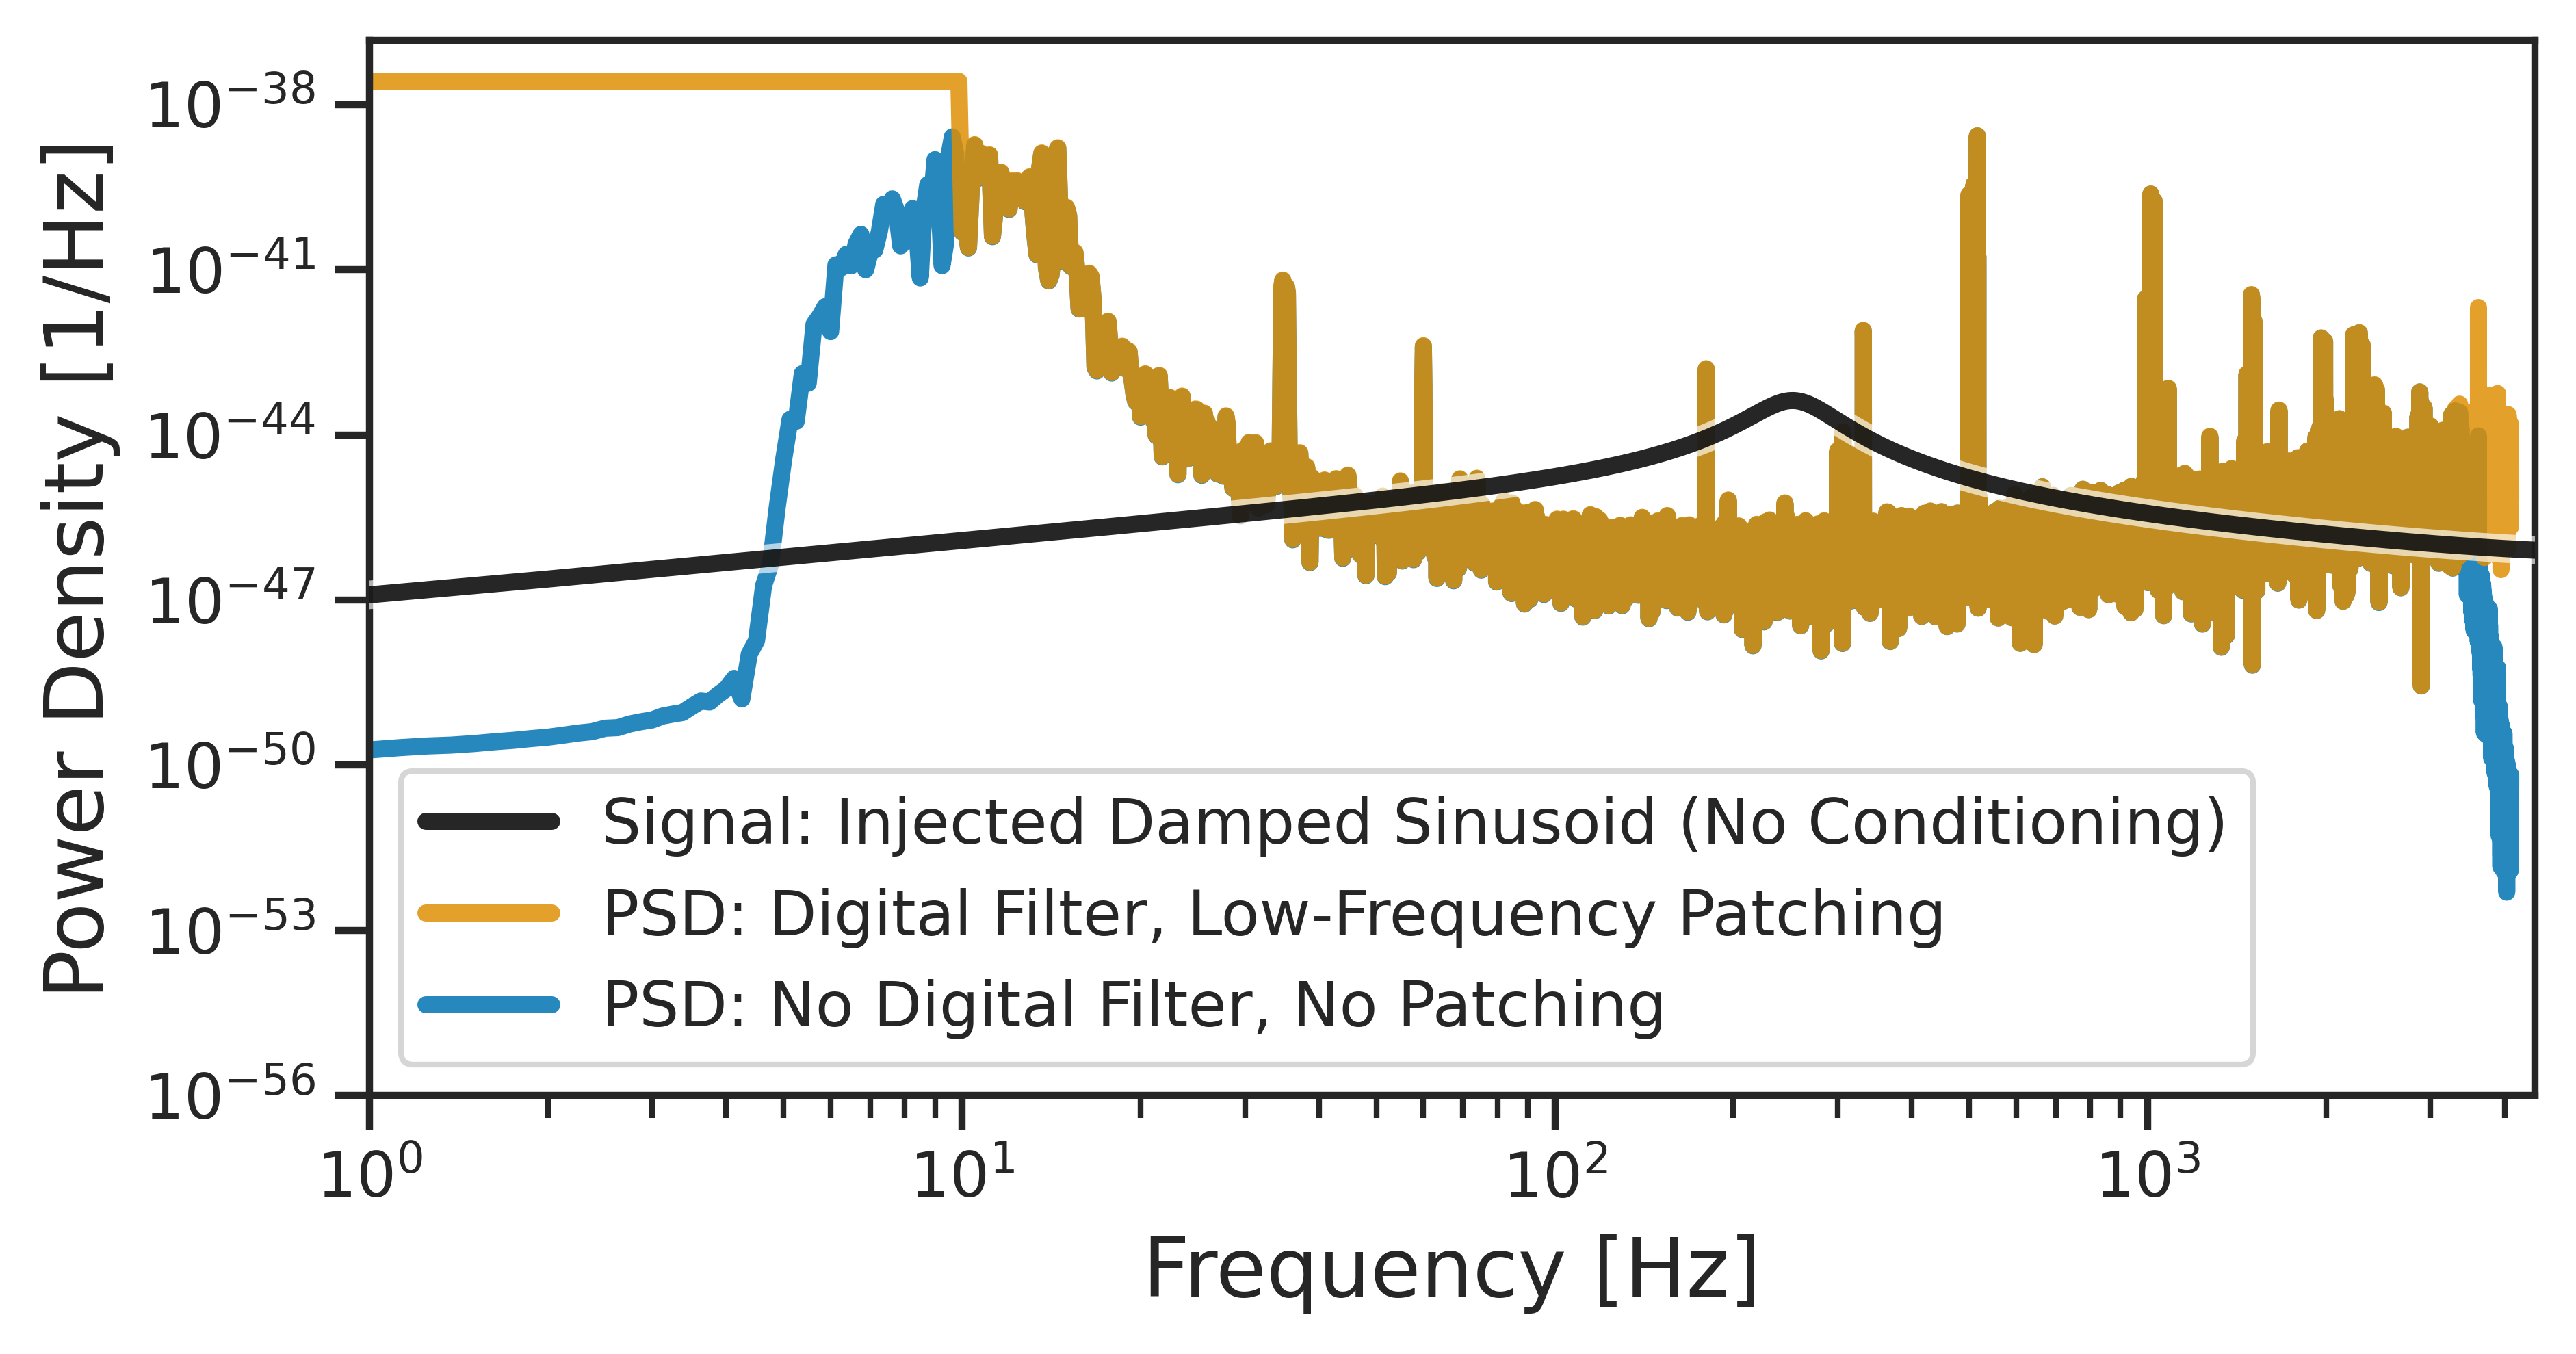

In [56]:
fig, ax = plt.subplots(1,1,figsize=[figsize_square[0],figsize_square[1]/2],dpi=300)

#t0 = 1242442967.4085817 # GW190521
t0 = 1126259462.423 # GW150914
ra = 5.749613171792332
dec = -0.4237903906862163
psi = 1.222853265910277
T = 0.4
ds=2
slice_dur = 256
alpha = 0.85

A = 3e-21 
f_qnm = 250.0
tau_qnm = 0.004
phase_qnm = 5.34 
dur = 0.5

lw = 3

cmap = sns.color_palette("colorblind")

noise_td = generate_noise()
times = noise_td.index

signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

signal_FT = np.fft.rfft(signal[64:64+dur].values)/(2**14)*2 #we multiply by 2 to account for throwing out half of the frequencies due to rfft, 
                                                                #in order to get the total power correct
    
delta_t = 1/2**14
freqs_analysis = np.fft.rfftfreq(len(noise_td[64:64+dur]), delta_t)

sig_power = ringdown.FrequencySeries(freqs_analysis*(signal_FT.real**2+signal_FT.imag**2),freqs_analysis)

plt.loglog(sig_power, color = "black", alpha = alpha,zorder = 10, label="Signal: Injected Damped Sinusoid (No Conditioning)",lw=lw,path_effects=[patheff.Stroke(linewidth=5, foreground='w',alpha=0.65), patheff.Normal()])

#Patching, digital filter
fit = ringdown.Fit(model="mchi")
fit.load_data({"L1":"/mnt/home/hsiegel/ceph/database_rd/GW150914_095045/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5"},kind="GWOSC")
fit.set_target(t0=t0, ra=ra, dec=dec, psi=psi, duration=T)
fit.condition_data(f_min=1/0.1,ds=ds,digital_filter=True,slice_left=slice_dur,slice_right=slice_dur)
nperseg = np2(16*fit.duration*(2**14)/ds)
fit.compute_acfs(method='fd', nperseg=nperseg,f_min=1/0.1) # flattened PSD
psd_digfilt = fit.acfs["L1"].to_psd()
plt.loglog(psd_digfilt,alpha=alpha, color = cmap[1], label = "PSD: Digital Filter, Low-Frequency Patching",lw=lw,zorder=0)

#No patch, no digital filter
fit = ringdown.Fit(model="mchi")
fit.load_data({"L1":"/mnt/home/hsiegel/ceph/database_rd/GW150914_095045/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5"},kind="GWOSC")
fit.set_target(t0=t0, ra=ra, dec=dec, psi=psi, duration=T)
fit.condition_data(f_min=1/0.1,ds=ds,digital_filter=False,slice_left=slice_dur,slice_right=slice_dur)
nperseg = np2(16*fit.duration*(2**14)/ds)
fit.compute_acfs(method='fd', nperseg=nperseg) # flattened PSD
psd = fit.acfs["L1"].to_psd()
plt.loglog(psd,alpha=alpha, color = cmap[0], label = "PSD: No Digital Filter, No Patching",lw=lw,zorder=-5)

#signal2 = ringdown.Data(signal).condition(t0=64,flow=10,fhigh=2**14/(2*2),ds=2)

#signal_FT2 = np.fft.rfft(signal2[64:64+dur].values)/(2**14)*2 #we multiply by 2 to account for throwing out half of the frequencies due to rfft, 
                                                                #in order to get the total power correct
    
#delta_t = 1/2**14
#freqs_analysis = np.fft.rfftfreq(len(noise_td[64:64+dur]), delta_t)

#sig_power2 = ringdown.FrequencySeries(freqs_analysis[::2]*(signal_FT2.real**2+signal_FT2.imag**2),freqs_analysis[0:int(len(freqs_analysis)/2)+1])

#plt.plot(sig_power2, color = "grey", alpha = alpha,zorder = 10, label="Signal: Injected Damped Sinusoid (Filtered)",lw=lw,path_effects=[patheff.Stroke(linewidth=5, foreground='w',alpha=0.65), patheff.Normal()])

ax.set_xlabel('Frequency [Hz]', fontsize = fs_label)
ax.set_ylabel("Power Density [1/Hz]", fontsize = fs_label)

ax.set_xlim(1,2**14/(2*ds)*1.1)
ax.set_ylim(1e-56,ax.get_ylim()[1])

plt.legend()
plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/GW150914_PSD",bbox_inches="tight")

## Downsampling

### No noise, single damped sinusoid

In [108]:
#Set up noise to estimate PSD
fit = ringdown.Fit.from_config("/mnt/home/hsiegel/ceph/conditioning_data_studies/injection_configs/plotting/gw150914_GR_phi5p34.ini")

sample_rate = 2**14
duration = 4096
noise_td, psd = generate_noise(lalpsd = True, rtrn_psd = True, dur=duration)

times = noise_td.index
t0 = duration/2
nperseg = np2(16*fit.duration*(sample_rate))

/mnt/home/hsiegel/ringdown/ringdown/fit.py:377: UserWarning: replacing deprecated option a_scale with a_scale_max
  warnings.warn(f"replacing deprecated option {k} with {new}")
/mnt/home/hsiegel/ringdown/ringdown/fit.py:377: UserWarning: replacing deprecated option flat_a with flat_amplitude_prior
  warnings.warn(f"replacing deprecated option {k} with {new}")


In [109]:
#compute PSD
fit3 = ringdown.Fit(modes=fit.modes)
fit3.set_target(t0=t0,duration = fit.duration)
fit3.add_data(noise_td)
fit3.condition_data(f_min=10,ds=1,digital_filter=True)
fit3.compute_acfs(method='fd', nperseg=nperseg, f_min = 10) # flattened PSD

psd = fit3.acfs[None].to_psd()

#### phi 1.2

In [114]:
results_dict = {}
results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"

for f in [x for x in sorted([y for y in os.listdir(results_dir) if ".csv" not in y and ".nc" in y and "SNR31" not in y and "cosinore" in y and "Digital" in y and "1mode" in y and "phi5p34" not in y],key = lambda x: int(x.split("ds")[1].split("_")[0]))]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)


GW150914_NOnoise_LIGODesignPSD_DigitalFilter_1mode_ds1_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_DigitalFilter_1mode_ds2_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_DigitalFilter_1mode_ds4_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_DigitalFilter_1mode_ds8_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_DigitalFilter_1mode_ds16_dur0p05s_cosinorestrict.nc


In [115]:
#compute power of signal FT
fit = ringdown.Fit.from_config("/mnt/home/hsiegel/ceph/conditioning_data_studies/injection_configs/plotting/gw150914_GR_phi1p2.ini")

signal_FT = np.fft.rfft(fit.analysis_data["H1"].values)/sample_rate*2 #we multiply by 2 to account for throwing out half of the frequencies due to rfft, 
                                                                #in order to get the total power correct
    
delta_t = 1/sample_rate
freqs_analysis = np.fft.rfftfreq(len(fit.analysis_data["H1"]), delta_t)

sig_power = ringdown.FrequencySeries(freqs_analysis*(signal_FT.real**2+signal_FT.imag**2),freqs_analysis)


/mnt/home/hsiegel/ringdown/ringdown/fit.py:377: UserWarning: replacing deprecated option a_scale with a_scale_max
  warnings.warn(f"replacing deprecated option {k} with {new}")
/mnt/home/hsiegel/ringdown/ringdown/fit.py:377: UserWarning: replacing deprecated option flat_a with flat_amplitude_prior
  warnings.warn(f"replacing deprecated option {k} with {new}")


Nyq = 8192.0
Nyq = 4096.0
Nyq = 2048.0
Nyq = 1024.0
Nyq = 512.0
1 0.71149474
2 0.72527134
4 0.70211565
8 0.6968707
16 1.4923428


/tmp/ipykernel_4099626/4231484306.py:64: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
/tmp/ipykernel_4099626/4231484306.py:64: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
/tmp/ipykernel_4099626/4231484306.py:64: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
/tmp/ipykernel_4099626/4231484306.py:64: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

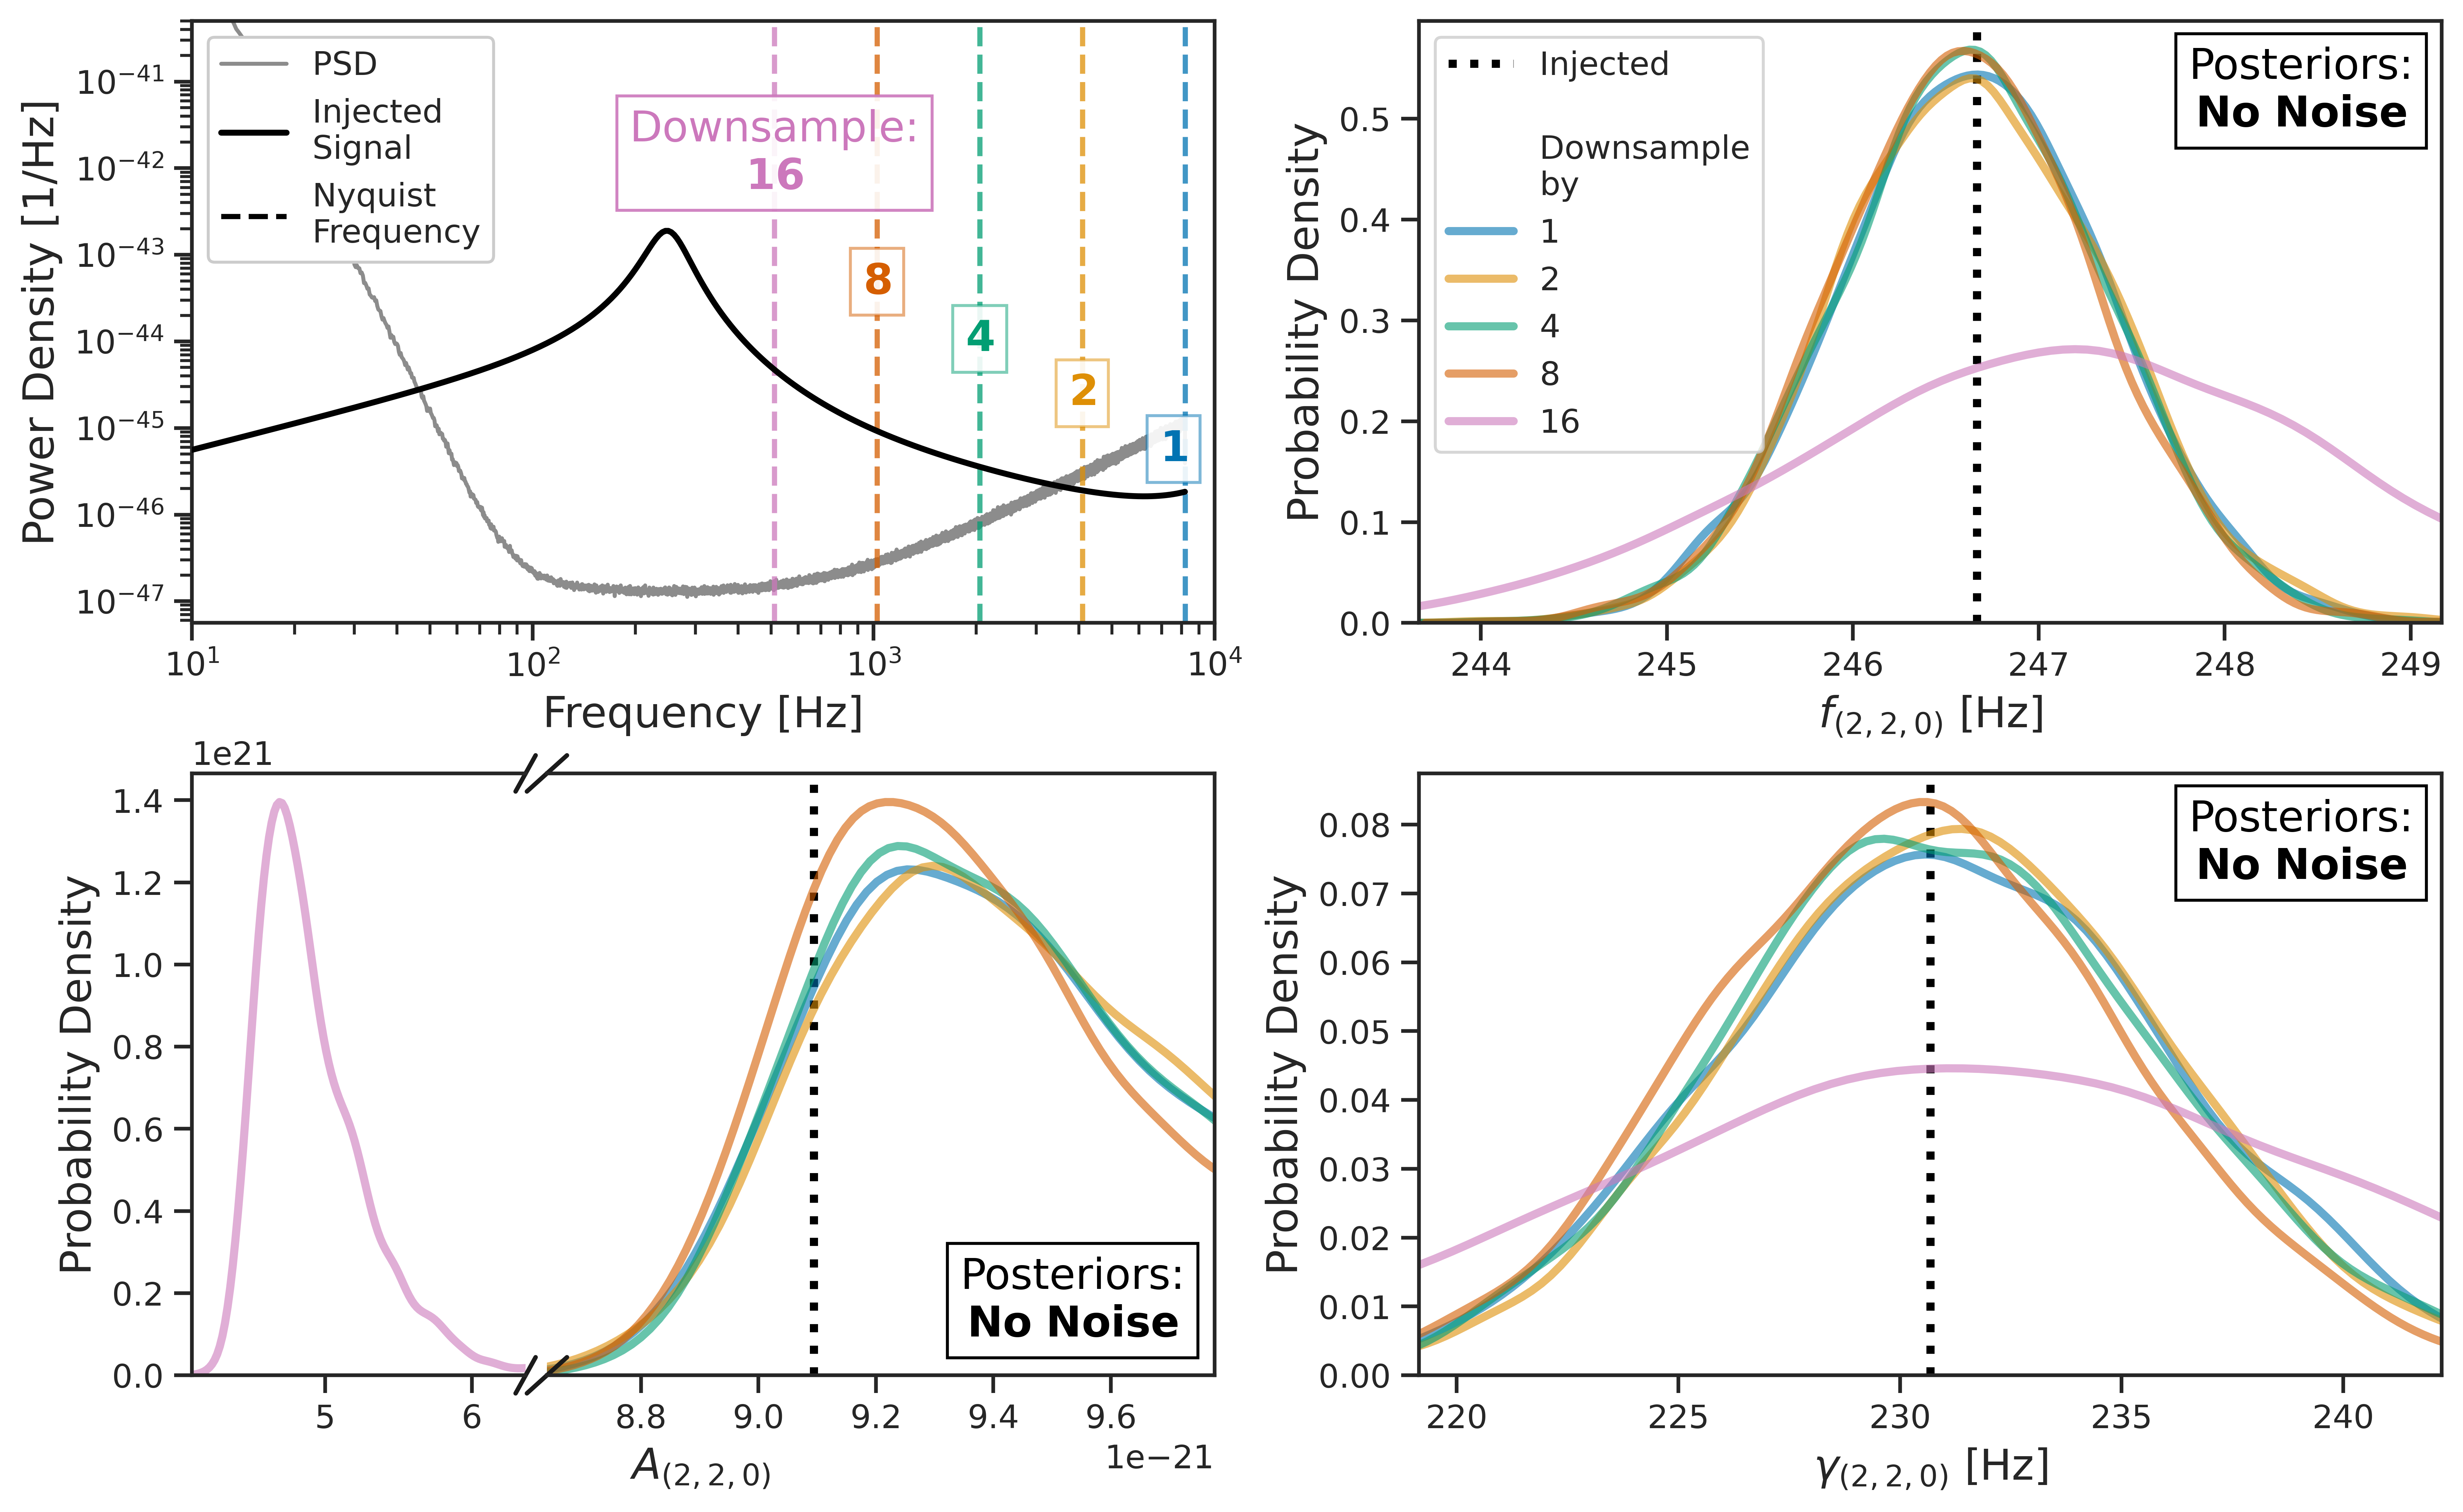

In [116]:
#plotting

fig, ax = plt.subplots(2,2, figsize = (fig_width*2,2*fig_height), dpi = 300)

cmap = sns.color_palette("colorblind")

small_lw = 2
med_lw = 2.75
big_lw = 3.5

ds_max = max(results_dict.keys())

#Plotting for ax[0]

delta_t = 1/sample_rate

ax[0][0].plot(psd.index, psd.values, label = "PSD", color = "grey", lw = small_lw*2/3, ls = "-", zorder = -100, alpha = 0.9)
        
ax[0][0].plot(sig_power, color = "black", label="Injected\nSignal", lw=small_lw, zorder = 100)

ax[0][0].set_ylim(min(psd)*0.5, 5e-41)
ax[0][0].set_xlim(10,10**4)
ax[0][0].set_yscale("log")
ax[0][0].set_xscale("log")
ax[0][0].set_xlabel('Frequency [Hz]',fontsize = fs_label)
ax[0][0].set_ylabel("Power Density [1/Hz]", fontsize = fs_label)
    
c_count = 0
lw = 1.75
lst = "--"
alpha = 0.75

#ann_slope = -3.2 #slope for producing straight lines on loglog plot
#b = np.log(5e-47)-ann_slope*np.log(8192) #y intercept for producing straight lines on loglog plot

ds_str = "["
for x in results_dict.keys():
    ds_str+=str(x)+", "
ds_str = ds_str[:-2]+"]"

for k,v in results_dict.items():
    nyq_freq = sample_rate/(2*k)
    print("Nyq =",nyq_freq)
    
    if k == 1:
        #ax[0].axvline(0,label = "Nyquist\nFrequency,\nDownsample by\n{}".format(ds_str),lw = lw, ls = lst, color= "black")
        ax[0][0].axvline(0,label = "Nyquist\nFrequency".format(ds_str),lw = lw, ls = lst, color= "black")
    if k==24:
        alpha = 0.95
        
    ax[0][0].axvline(nyq_freq, ls=lst,color=cmap[c_count],lw = lw, alpha = alpha)
        
    if k==1:
        #ann_offset_x = -3700
        ann_offset_x = -600
    else:
        ann_offset_x = 0
    
    x=nyq_freq+ann_offset_x
    #y=np.exp(np.log(x)*ann_slope)*np.exp(b) # produce straight lines on a loglog plot
    y_offset = (c_count+1)**2/7
    if k ==ds_max:
        y_offset = y_offset*2
    y = sig_power.iloc()[sig_power.index.get_loc(x,method = "nearest")] * 1.7e1 * y_offset
    
    if k==ds_max:
        ax[0][0].annotate('Downsample:\n' + r'$\bf{{{}}}$'.format(str(k)),xy=[x,y],fontsize=fs_label, color=cmap[c_count],ha="center", bbox=dict(fc=clrs.to_rgba("white")[:-1] + (0.9,),ec=clrs.to_rgba(cmap[c_count])[:-1]+(0.9,),boxstyle="square"),zorder = -k+100)
    else:
        ax[0][0].annotate(r'$\bf{{{}}}$'.format(str(k)),xy=[x,y],fontsize=fs_label, color=cmap[c_count],ha="center", bbox=dict(fc=clrs.to_rgba("white")[:-1] + (0.9,),ec=clrs.to_rgba(cmap[c_count])[:-1]+(0.5,) ,boxstyle="square"),zorder = -k+100)
    c_count +=1

ax[0][0].legend(loc="upper left",framealpha=1)

    
#Plotting for ax[1]

f_inj = fit.info['injection']['f'][0]
ax[0][1].axvline(f_inj, ls = ":", zorder = -10, color="black", label = "Injected",lw=med_lw)
ax[0][1].axvline(f_inj, zorder = -10, lw=0, color=None, label = "\nDownsample\nby")
alpha = 0.6
c_count = 0
#lw = small_lw
lw = med_lw
for k,v in results_dict.items():
    sns.kdeplot(v.posterior.f.sel(mode=b'1,-2,2,2,0').values.flatten(),label = k, linewidth=lw, alpha = alpha, ax = ax[0][1],color=cmap[c_count])
    #sns.histplot(v.posterior.f.sel(mode=b'1,-2,2,2,0').values.flatten(),label = k, linewidth=lw, alpha = 0, ax = ax[0][1],color=cmap[c_count],element = "step")
    print(k, np.std(v.posterior.f.values.flatten()))
    c_count +=1


#ax[1].set_xlim(f_inj-10,f_inj+5)
ax[0][1].set_xlim(f_inj-3,f_inj+2.5)
ann_box_offset_x = 0.8625
ann_box_offset_y = 0.825
ax[0][1].annotate("Posteriors:\n" + r'$\bf{No~Noise}$', xy=[ax[0][1].get_xlim()[0]+(ax[0][1].get_xlim()[1]-ax[0][1].get_xlim()[0])*ann_box_offset_x, ax[0][1].get_ylim()[0]+(ax[0][1].get_ylim()[1]-ax[0][1].get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))
ax[0][1].legend(loc = "upper left")
ax[0][1].set_xlabel(r'$f_{(2,2,0)}$' + " [Hz]",fontsize = fs_label)
ax[0][1].set_ylabel("Probability Density",fontsize = fs_label)

#Plotting for ax[2]

#we're splitting the axes because one posterior is flying off in space
divider = make_axes_locatable(ax[1][0])
ax_split = divider.new_horizontal(size="200%", pad=0.1)
fig.add_axes(ax_split)

ax[1][0].spines['right'].set_visible(False)
ax_split.spines['left'].set_visible(False)

a_inj = fit.info['injection']['a'][0]
ax_split.axvline(a_inj, ls = ":", zorder = -10, color="black", label = "Injected",lw=med_lw)
ax_split.axvline(a_inj, zorder = -10, lw=0, color=None, label = "\nDownsample\nby")
alpha = 0.6
c_count = 0
#lw = small_lw
lw = med_lw
for k,v in results_dict.items():
    if k!=16:
        sns.kdeplot(v.posterior.a.sel(mode=b'1,-2,2,2,0').values.flatten(),label = k, linewidth=lw, alpha = alpha, ax = ax_split,color=cmap[c_count])
        c_count +=1


for k,v in results_dict.items():
    sns.kdeplot(v.posterior.a.sel(mode=b'1,-2,2,2,0').values.flatten(),label = k, linewidth=lw, alpha = alpha, ax = ax[1][0],color=cmap[c_count])
        
d = .03  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax[1][0].transAxes, color='k', clip_on=False)
ax[1][0].plot((1-d, 1+d), (-d, +d), **kwargs)
ax[1][0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax_split.transAxes)  # switch to the bottom axes
ax_split.plot((-d, +d), (1-d, 1+d), **kwargs)
ax_split.plot((-d, +d), (-d, +d), **kwargs)

#ax[1].set_xlim(f_inj-10,f_inj+5)
ax_split.set_xlim(a_inj*0.95,a_inj*1.075)
ax[1][0].set_xlim(a_inj*0.45,a_inj*0.7)
ax[1][0].xaxis.get_offset_text().set_visible(False)
ann_box_offset_x = 0.7875
ann_box_offset_y = 0.065
ax_split.annotate("Posteriors:\n" + r'$\bf{No~Noise}$', xy=[ax_split.get_xlim()[0]+(ax_split.get_xlim()[1]-ax_split.get_xlim()[0])*ann_box_offset_x, ax_split.get_ylim()[0]+(ax_split.get_ylim()[1]-ax_split.get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))
ax[1][0].set_xlabel(r'$A_{(2,2,0)}$',fontsize = fs_label)
ax[1][0].xaxis.set_label_coords(0.3, 0.085, transform=fig.transFigure)
ax[1][0].set_ylabel("Probability Density",fontsize = fs_label)
ax_split.tick_params(left=False,labelleft=False)
ax_split.set(ylabel=None)

#Plotting for ax[3]

g_inj = fit.info['injection']['gamma'][0]
ax[1][1].axvline(g_inj, ls = ":", zorder = -10, color="black", label = "Injected",lw=med_lw)
ax[1][1].axvline(g_inj, zorder = -10, lw=0, color=None, label = "\nDownsample\nby")
alpha = 0.6
c_count = 0
#lw = small_lw
lw = med_lw
for k,v in results_dict.items():
    sns.kdeplot(v.posterior.g.sel(mode=b'1,-2,2,2,0').values.flatten(),label = k, linewidth=lw, alpha = alpha, ax = ax[1][1],color=cmap[c_count])
    c_count +=1


#ax[1].set_xlim(f_inj-10,f_inj+5)
ax[1][1].set_xlim(g_inj*0.95,g_inj*1.05)
ann_box_offset_x = 0.8625
ann_box_offset_y = 0.825
ax[1][1].annotate("Posteriors:\n" + r'$\bf{No~Noise}$', xy=[ax[1][1].get_xlim()[0]+(ax[1][1].get_xlim()[1]-ax[1][1].get_xlim()[0])*ann_box_offset_x, ax[1][1].get_ylim()[0]+(ax[1][1].get_ylim()[1]-ax[1][1].get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))
ax[1][1].set_xlabel(r'$\gamma_{(2,2,0)}$'+" [Hz]",fontsize = fs_label)
ax[1][1].set_ylabel("Probability Density",fontsize = fs_label)

plt.subplots_adjust(hspace=0.25)

plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/downsample_bias_NOnoise_appendix",bbox_inches="tight")

In [117]:
print("Optimal SNR single ifo",np.sqrt(np.sum(np.square(fit3.acfs[None].whiten(fit.analysis_data["H1"])))))

Optimal SNR single ifo 69.0353589220047


### Digital vs Analog Filter, 2 modes

/mnt/home/hsiegel/ringdown/ringdown/fit.py:377: UserWarning: replacing deprecated option a_scale with a_scale_max
  warnings.warn(f"replacing deprecated option {k} with {new}")
/mnt/home/hsiegel/ringdown/ringdown/fit.py:377: UserWarning: replacing deprecated option flat_a with flat_amplitude_prior
  warnings.warn(f"replacing deprecated option {k} with {new}")


GW150914_NOnoise_LIGODesignPSD_DigitalFilter_2mode_ds1_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_DigitalFilter_2mode_ds2_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_DigitalFilter_2mode_ds4_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_DigitalFilter_2mode_ds8_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_DigitalFilter_2mode_ds16_dur0p05s_cosinorestrict.nc


/mnt/home/hsiegel/miniconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/home/hsiegel/miniconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/home/hsiegel/miniconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

GW150914_NOnoise_LIGODesignPSD_AnalogFilter_2mode_ds1_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_AnalogFilter_2mode_ds2_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_AnalogFilter_2mode_ds4_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_AnalogFilter_2mode_ds8_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_AnalogFilter_2mode_ds16_dur0p05s_cosinorestrict.nc


/mnt/home/hsiegel/miniconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/home/hsiegel/miniconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/home/hsiegel/miniconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

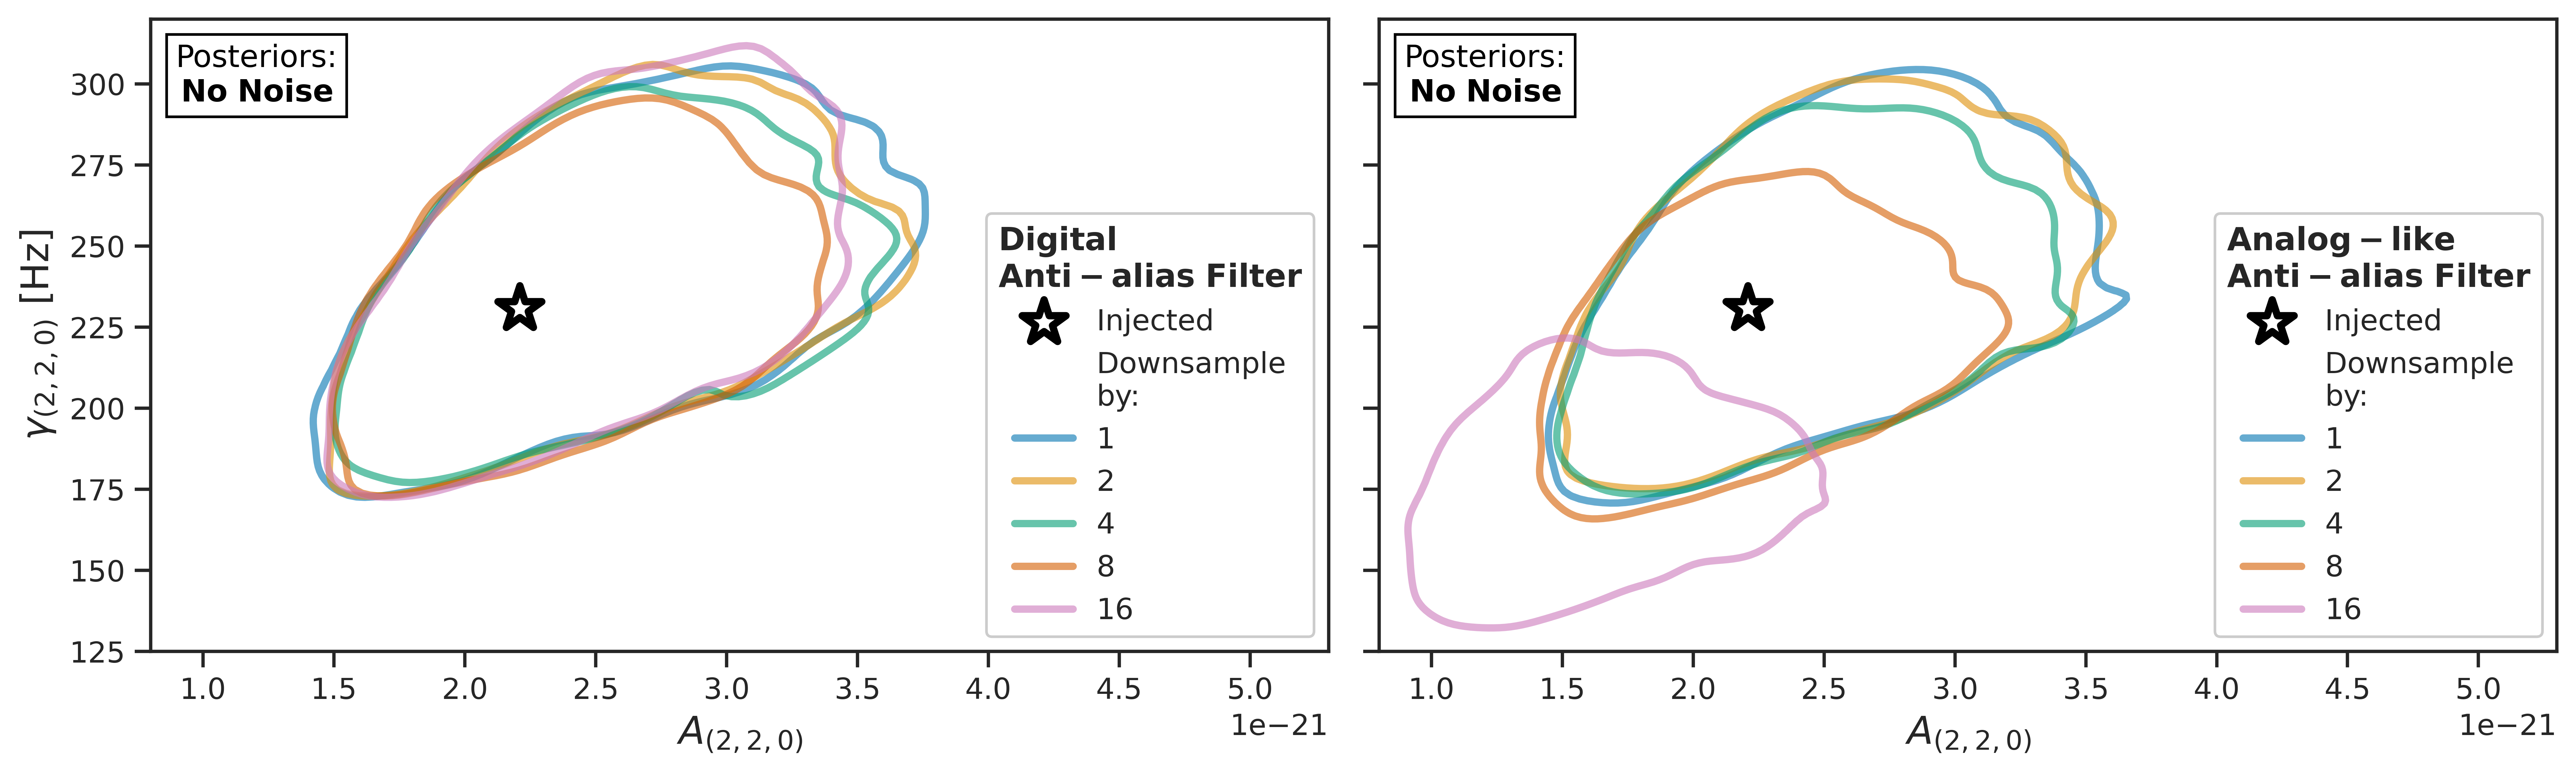

In [135]:
fig, ax = plt.subplots(1,2, figsize = (fig_width*2,fig_height), dpi = 300, sharey=True)

c_map = sns.color_palette("colorblind")
alpha = 0.6
markersize=300
levels = [0.1]
results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}

fit = ringdown.Fit.from_config("/mnt/home/hsiegel/ceph/conditioning_data_studies/injection_configs/downsampling_studies/cc_gw150914_nonoise_fdacf_mchi_aligned_N1_map_ds1.ini")

for f in [x for x in sorted([y for y in os.listdir(results_dir) if ".csv" not in y and ".nc" in y and "cosinore" in y and "Digital" in y and "2mode" in y and "TGR" not in y],key = lambda x: int(x.split("ds")[1].split("_")[0]))]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)
    
A = fit.info['injection']['a'][0]
f_qnm = fit.info['injection']['f'][0]
tau_qnm = fit.info['injection']['tau'][0]
phase_qnm = fit.info['injection']['phi'][0]

ax[0].scatter(A,1/tau_qnm,marker="*",s=markersize,color="white",ec="black",label="Injected",zorder=100,lw = med_lw)
#ax[0].axvline(A, ls = ":", zorder = -10, color="black", label = "Injected",lw=med_lw)
#ax[0].axhline(1/tau_qnm, ls = ":", zorder = -10, color="black", lw=med_lw)
ax[0].axvline(0, lw = 0, color=None,label="Downsample\nby:")
cnt = 0
for k,v in results_dict.items():
    if k == 32:
        continue
    sns.kdeplot(v.posterior.a.sel(mode=b'1,-2,2,2,0').values.flatten(),
                v.posterior.g.sel(mode=b'1,-2,2,2,0').values.flatten(),
                levels=levels, color=c_map[cnt],linewidths = med_lw,alpha=alpha,ax=ax[0], linestyles = "-")
    ax[0].axvline(-1, lw = med_lw, color=c_map[cnt],label=k,alpha=alpha,ls="-")
    cnt+=1

ax[0].legend(title=r'$\bf{Digital}$'+'\n'+r'$\bf{Anti-alias~Filter}$',framealpha=1,loc="lower right")

results_dict = {}
for f in [x for x in sorted([y for y in os.listdir(results_dir) if ".csv" not in y and ".nc" in y and "cosinore" in y and "Analog" in y and "2mode" in y and "TGR" not in y],key = lambda x: int(x.split("ds")[1].split("_")[0]))]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)

ax[1].scatter(A,1/tau_qnm,marker="*",s=markersize,color="white",ec="black",label="Injected",zorder=100,lw = med_lw)
#ax[1].axvline(A, ls = ":", zorder = -10, color="black", label = "Injected",lw=med_lw)
#ax[1].axhline(1/tau_qnm, ls = ":", zorder = -10, color="black", lw=med_lw)
ax[1].axvline(0, lw = 0, color=None,label="Downsample\nby:")
cnt = 0
for k,v in results_dict.items():
    if k == 32:
        continue
    sns.kdeplot(v.posterior.a.sel(mode=b'1,-2,2,2,0').values.flatten(),
                v.posterior.g.sel(mode=b'1,-2,2,2,0').values.flatten(),
                levels=levels, color=c_map[cnt], linewidths = med_lw,linestyles="-",alpha=alpha,ax=ax[1])
    ax[1].axvline(-1, lw = med_lw, ls = "-", color=c_map[cnt],label=k,alpha=alpha)
    cnt+=1

ax[1].legend(title=r'$\bf{Analog-like}$'+'\n'+r'$\bf{Anti-alias~Filter}$',framealpha=1,loc="lower right")
    
ax[0].set_xlim(0.8e-21,0.53e-20)
ax[1].set_xlim(0.8e-21,0.53e-20)

ax[0].set_ylim(125,320)
ax[1].set_ylim(125,320)


ax[0].set_ylabel(r'$\gamma_{(2,2,0)}$' + " [Hz]", fontsize = fs_label)
ax[0].set_xlabel(r'$A_{(2,2,0)}$', fontsize = fs_label)
ax[1].set_xlabel(r'$A_{(2,2,0)}$', fontsize = fs_label)

ann_box_offset_x = 1 - (0.845+0.065)
ann_box_offset_y = 0.845+0.025
ax[0].annotate("Posteriors:\n" + r'$\bf{No~Noise}$', xy=[ax[0].get_xlim()[0]+(ax[0].get_xlim()[1]-ax[0].get_xlim()[0])*ann_box_offset_x, ax[0].get_ylim()[0]+(ax[0].get_ylim()[1]-ax[0].get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label*0.8, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))

ann_box_offset_x = 1 - (0.845+0.065)
ann_box_offset_y = 0.845 + 0.025
ax[1].annotate("Posteriors:\n" + r'$\bf{No~Noise}$', xy=[ax[1].get_xlim()[0]+(ax[1].get_xlim()[1]-ax[1].get_xlim()[0])*ann_box_offset_x, ax[1].get_ylim()[0]+(ax[1].get_ylim()[1]-ax[1].get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label*0.8, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))

#ax[0].grid(ls="--")
#ax[1].grid(ls="--")

fig.tight_layout()
#plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/digital_vs_analog_filter",bbox_inches="tight")

/mnt/home/hsiegel/ringdown/ringdown/fit.py:377: UserWarning: replacing deprecated option a_scale with a_scale_max
  warnings.warn(f"replacing deprecated option {k} with {new}")
/mnt/home/hsiegel/ringdown/ringdown/fit.py:377: UserWarning: replacing deprecated option flat_a with flat_amplitude_prior
  warnings.warn(f"replacing deprecated option {k} with {new}")


GW150914_NOnoise_LIGODesignPSD_DigitalFilter_2mode_ds1_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_DigitalFilter_2mode_ds2_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_DigitalFilter_2mode_ds4_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_DigitalFilter_2mode_ds8_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_DigitalFilter_2mode_ds16_dur0p05s_cosinorestrict.nc


/mnt/home/hsiegel/miniconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/home/hsiegel/miniconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/home/hsiegel/miniconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

GW150914_NOnoise_LIGODesignPSD_AnalogFilter_2mode_ds1_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_AnalogFilter_2mode_ds2_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_AnalogFilter_2mode_ds4_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_AnalogFilter_2mode_ds8_dur0p05s_cosinorestrict.nc
GW150914_NOnoise_LIGODesignPSD_AnalogFilter_2mode_ds16_dur0p05s_cosinorestrict.nc


/mnt/home/hsiegel/miniconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/home/hsiegel/miniconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/home/hsiegel/miniconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will re

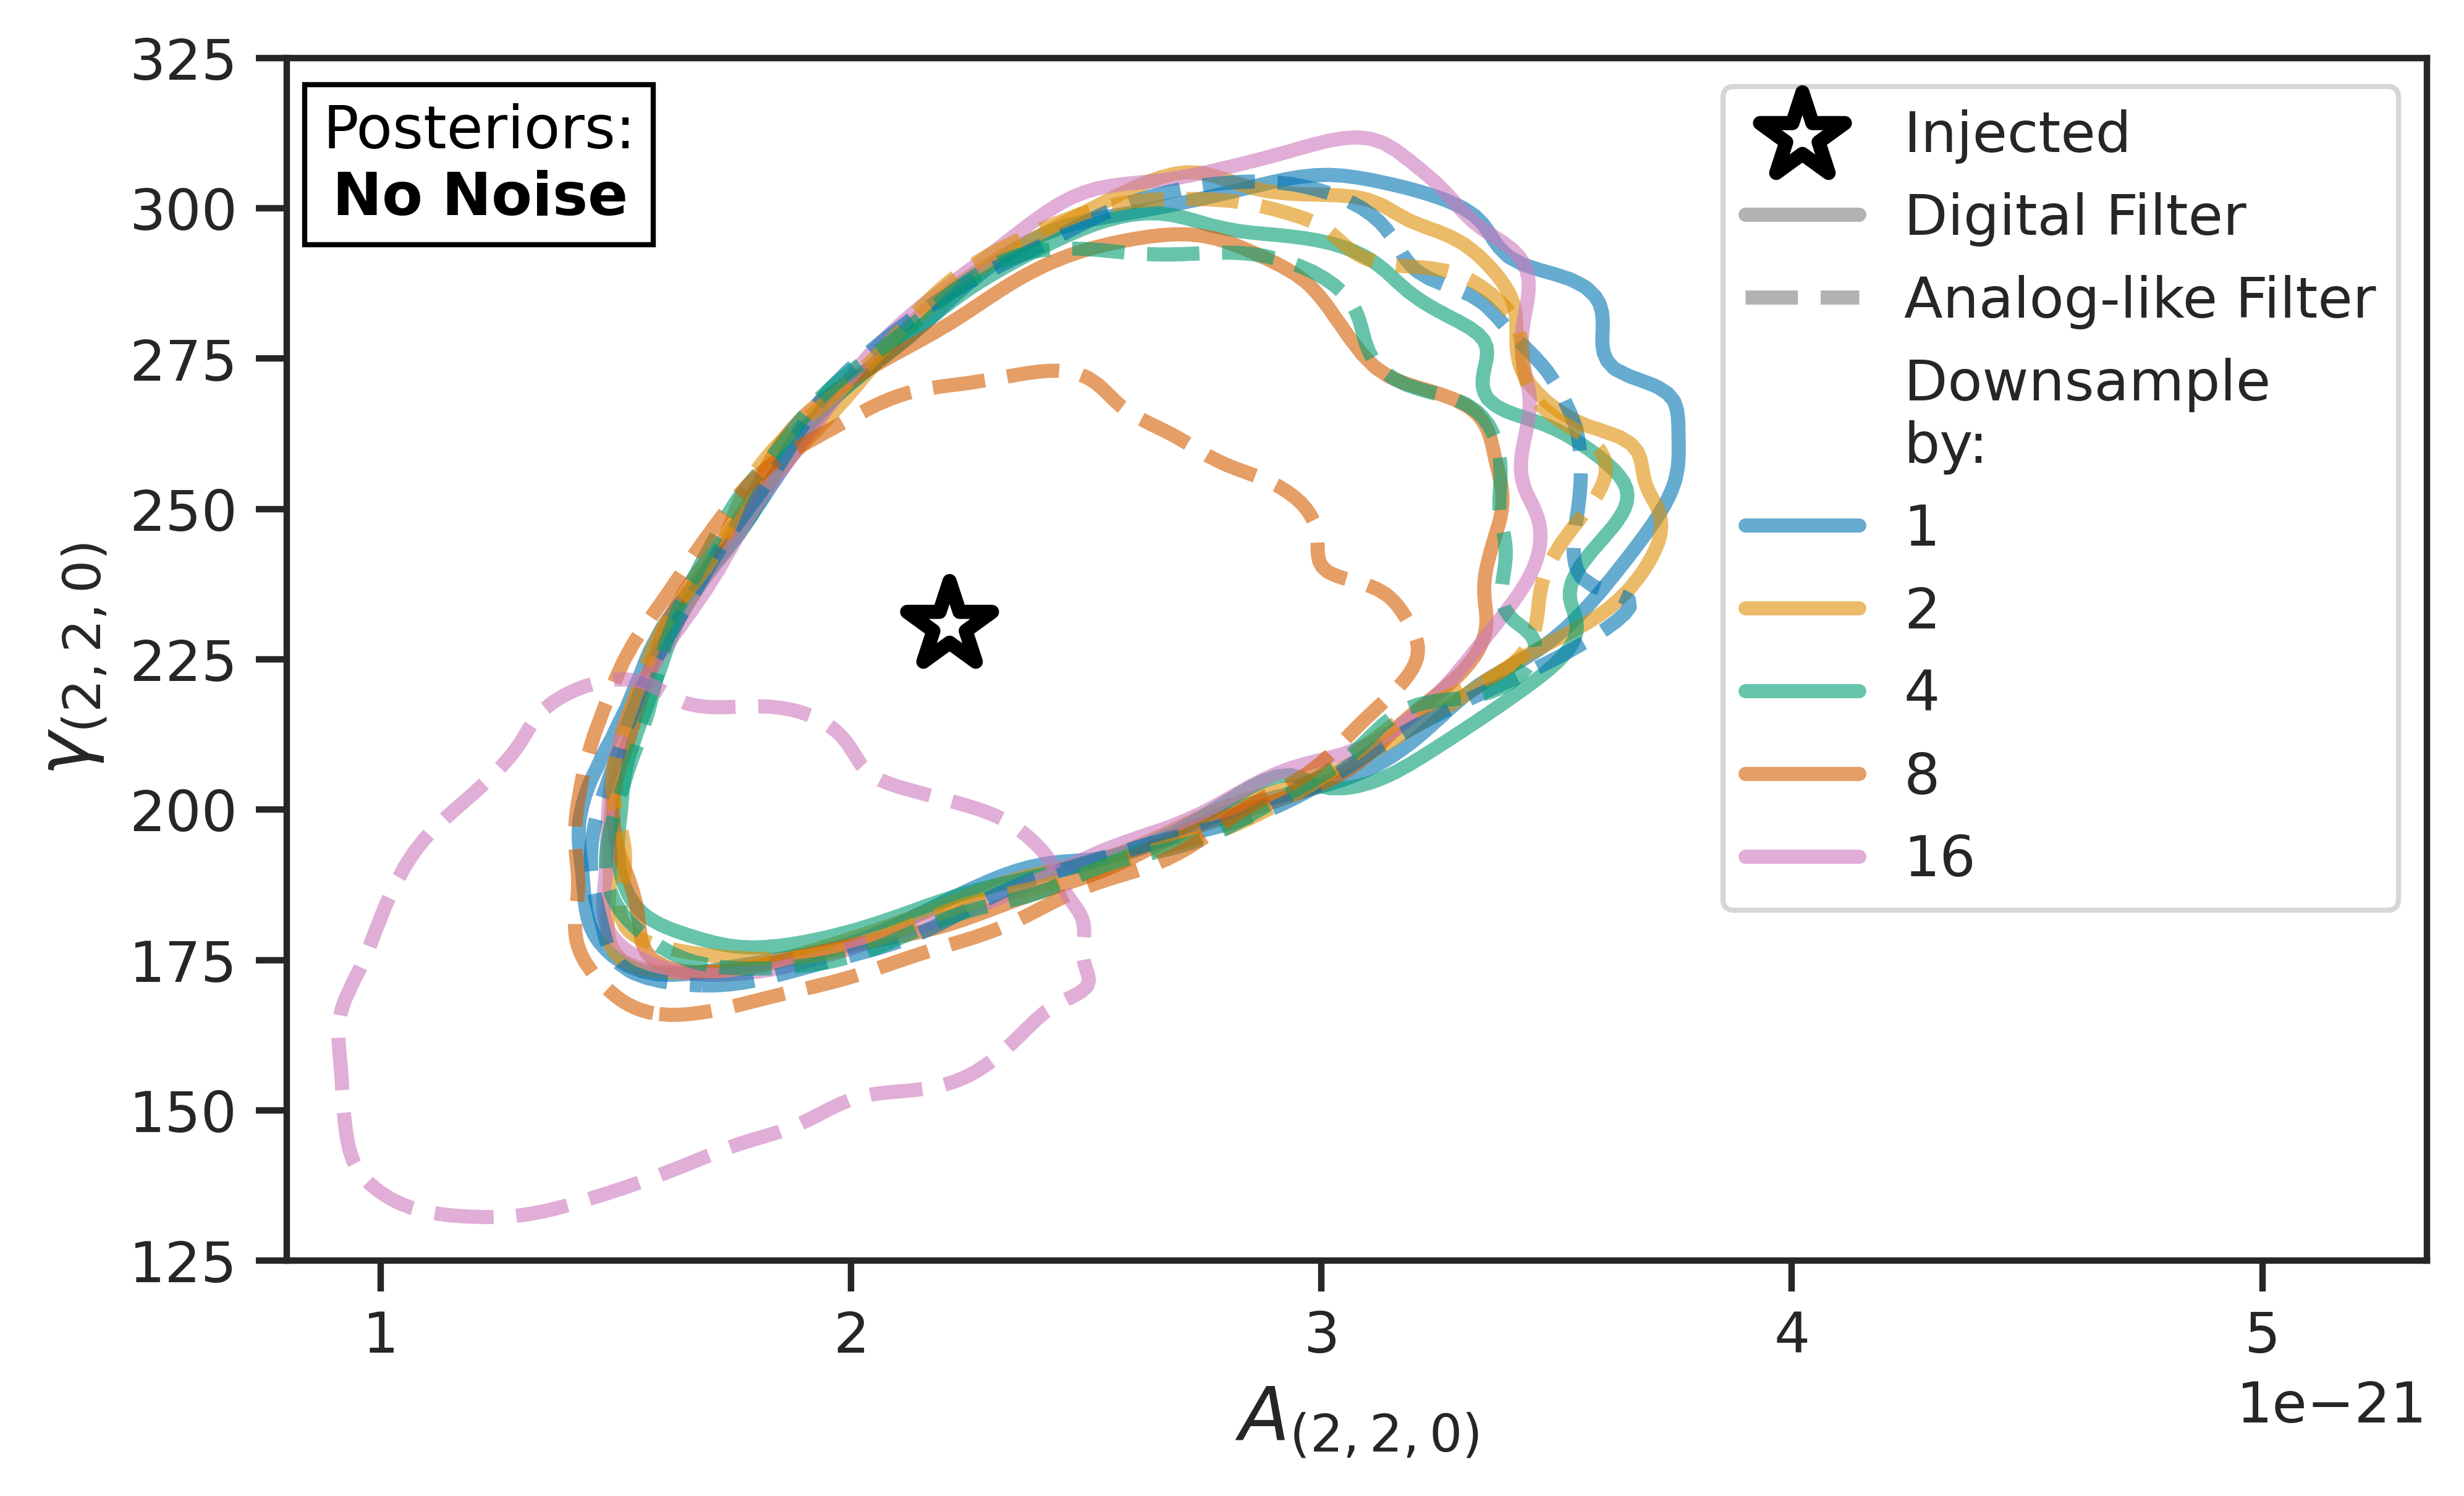

In [149]:
fig, ax = plt.subplots(1,1, figsize = (fig_width,fig_height), dpi = 300, sharey=True)

c_map = sns.color_palette("colorblind")
alpha = 0.6
markersize=300
levels = [0.1]
results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}

fit = ringdown.Fit.from_config("/mnt/home/hsiegel/ceph/conditioning_data_studies/injection_configs/downsampling_studies/cc_gw150914_nonoise_fdacf_mchi_aligned_N1_map_ds1.ini")

for f in [x for x in sorted([y for y in os.listdir(results_dir) if ".csv" not in y and ".nc" in y and "cosinore" in y and "Digital" in y and "2mode" in y],key = lambda x: int(x.split("ds")[1].split("_")[0]))]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)
    
A = fit.info['injection']['a'][0]
f_qnm = fit.info['injection']['f'][0]
tau_qnm = fit.info['injection']['tau'][0]
phase_qnm = fit.info['injection']['phi'][0]

ax.scatter(A,1/tau_qnm,marker="*",s=markersize,color="white",ec="black",label="Injected",zorder=100,lw = med_lw)
ax.axvline(-1, lw = med_lw, color="grey",label="Digital Filter",alpha=alpha)
ax.axvline(-1, lw = med_lw, color="grey",ls="--",label="Analog-like Filter",alpha=alpha)
ax.axvline(-1, lw = 0, color=None,label="Downsample\nby:")
cnt = 0
for k,v in results_dict.items():
    if k == 32:
        continue
    sns.kdeplot(v.posterior.a.sel(mode=b'1,-2,2,2,0').values.flatten(),
                v.posterior.g.sel(mode=b'1,-2,2,2,0').values.flatten(),
                levels=levels, color=c_map[cnt],linewidths = med_lw,alpha=alpha,ax=ax, linestyles = "-")
    ax.axvline(-1, lw = med_lw, color=c_map[cnt],label=k,alpha=alpha,ls="-")
    cnt+=1

results_dict = {}
for f in [x for x in sorted([y for y in os.listdir(results_dir) if ".csv" not in y and ".nc" in y and "cosinore" in y and "Analog" in y and "2mode" in y],key = lambda x: int(x.split("ds")[1].split("_")[0]))]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)

cnt = 0
for k,v in results_dict.items():
    if k == 32:
        continue
    sns.kdeplot(v.posterior.a.sel(mode=b'1,-2,2,2,0').values.flatten(),
                v.posterior.g.sel(mode=b'1,-2,2,2,0').values.flatten(),
                levels=levels, color=c_map[cnt], linewidths = med_lw,linestyles="--",alpha=alpha,ax=ax)
    cnt+=1

ax.legend()
    
ax.set_xlim(0.8e-21,0.535e-20)
ax.set_ylim(125,325)

ax.set_ylabel(r'$\gamma_{(2,2,0)}$', fontsize = fs_label)
ax.set_xlabel(r'$A_{(2,2,0)}$', fontsize = fs_label)

ann_box_offset_x = 1 - (0.845+0.065)
ann_box_offset_y = 0.845+0.025
ax.annotate("Posteriors:\n" + r'$\bf{No~Noise}$', xy=[ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*ann_box_offset_x, ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label*0.8, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))

fig.tight_layout()
#plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/digital_vs_analog_filter",bbox_inches="tight")

### TGR

In [136]:
results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/"
results_dict = {}
for f in [x for x in sorted([y for y in os.listdir(results_dir) if "TGR" in y],key = lambda x: int(x.split("ds")[1].split("_")[0]))]:
    print(f)
    results_dict[int(f.split("ds")[1].split("_")[0])] = az.from_netcdf(results_dir + f)

TGR_GW150914_NOnoise_LIGODesignPSD_DigitalFilter_2modes_ds1_dur0p05s_cosinorestrict.nc
TGR_GW150914_NOnoise_LIGODesignPSD_DigitalFilter_2modes_ds2_dur0p05s_cosinorestrict.nc
TGR_GW150914_NOnoise_LIGODesignPSD_DigitalFilter_2modes_ds4_dur0p05s_cosinorestrict.nc
TGR_GW150914_NOnoise_LIGODesignPSD_DigitalFilter_2modes_ds8_dur0p05s_cosinorestrict.nc
TGR_GW150914_NOnoise_LIGODesignPSD_DigitalFilter_2modes_ds16_dur0p05s_cosinorestrict.nc


In [137]:
# to plot injections
fit_mode1 = ringdown.Fit.from_config("/mnt/home/hsiegel/ceph/conditioning_data_studies/injection_configs/plotting/TGR_mode1.ini")
fit_mode2 = ringdown.Fit.from_config("/mnt/home/hsiegel/ceph/conditioning_data_studies/injection_configs/plotting/TGR_mode2.ini")

/mnt/home/hsiegel/ringdown/ringdown/fit.py:377: UserWarning: replacing deprecated option a_scale with a_scale_max
  warnings.warn(f"replacing deprecated option {k} with {new}")
/mnt/home/hsiegel/ringdown/ringdown/fit.py:377: UserWarning: replacing deprecated option flat_a with flat_amplitude_prior
  warnings.warn(f"replacing deprecated option {k} with {new}")
/mnt/home/hsiegel/ringdown/ringdown/fit.py:377: UserWarning: replacing deprecated option a_scale with a_scale_max
  warnings.warn(f"replacing deprecated option {k} with {new}")
/mnt/home/hsiegel/ringdown/ringdown/fit.py:377: UserWarning: replacing deprecated option flat_a with flat_amplitude_prior
  warnings.warn(f"replacing deprecated option {k} with {new}")


In [138]:
signal1 = fit_mode1.analysis_data["H1"]
signal2 = fit_mode2.analysis_data["H1"]
signal = signal1 + signal2

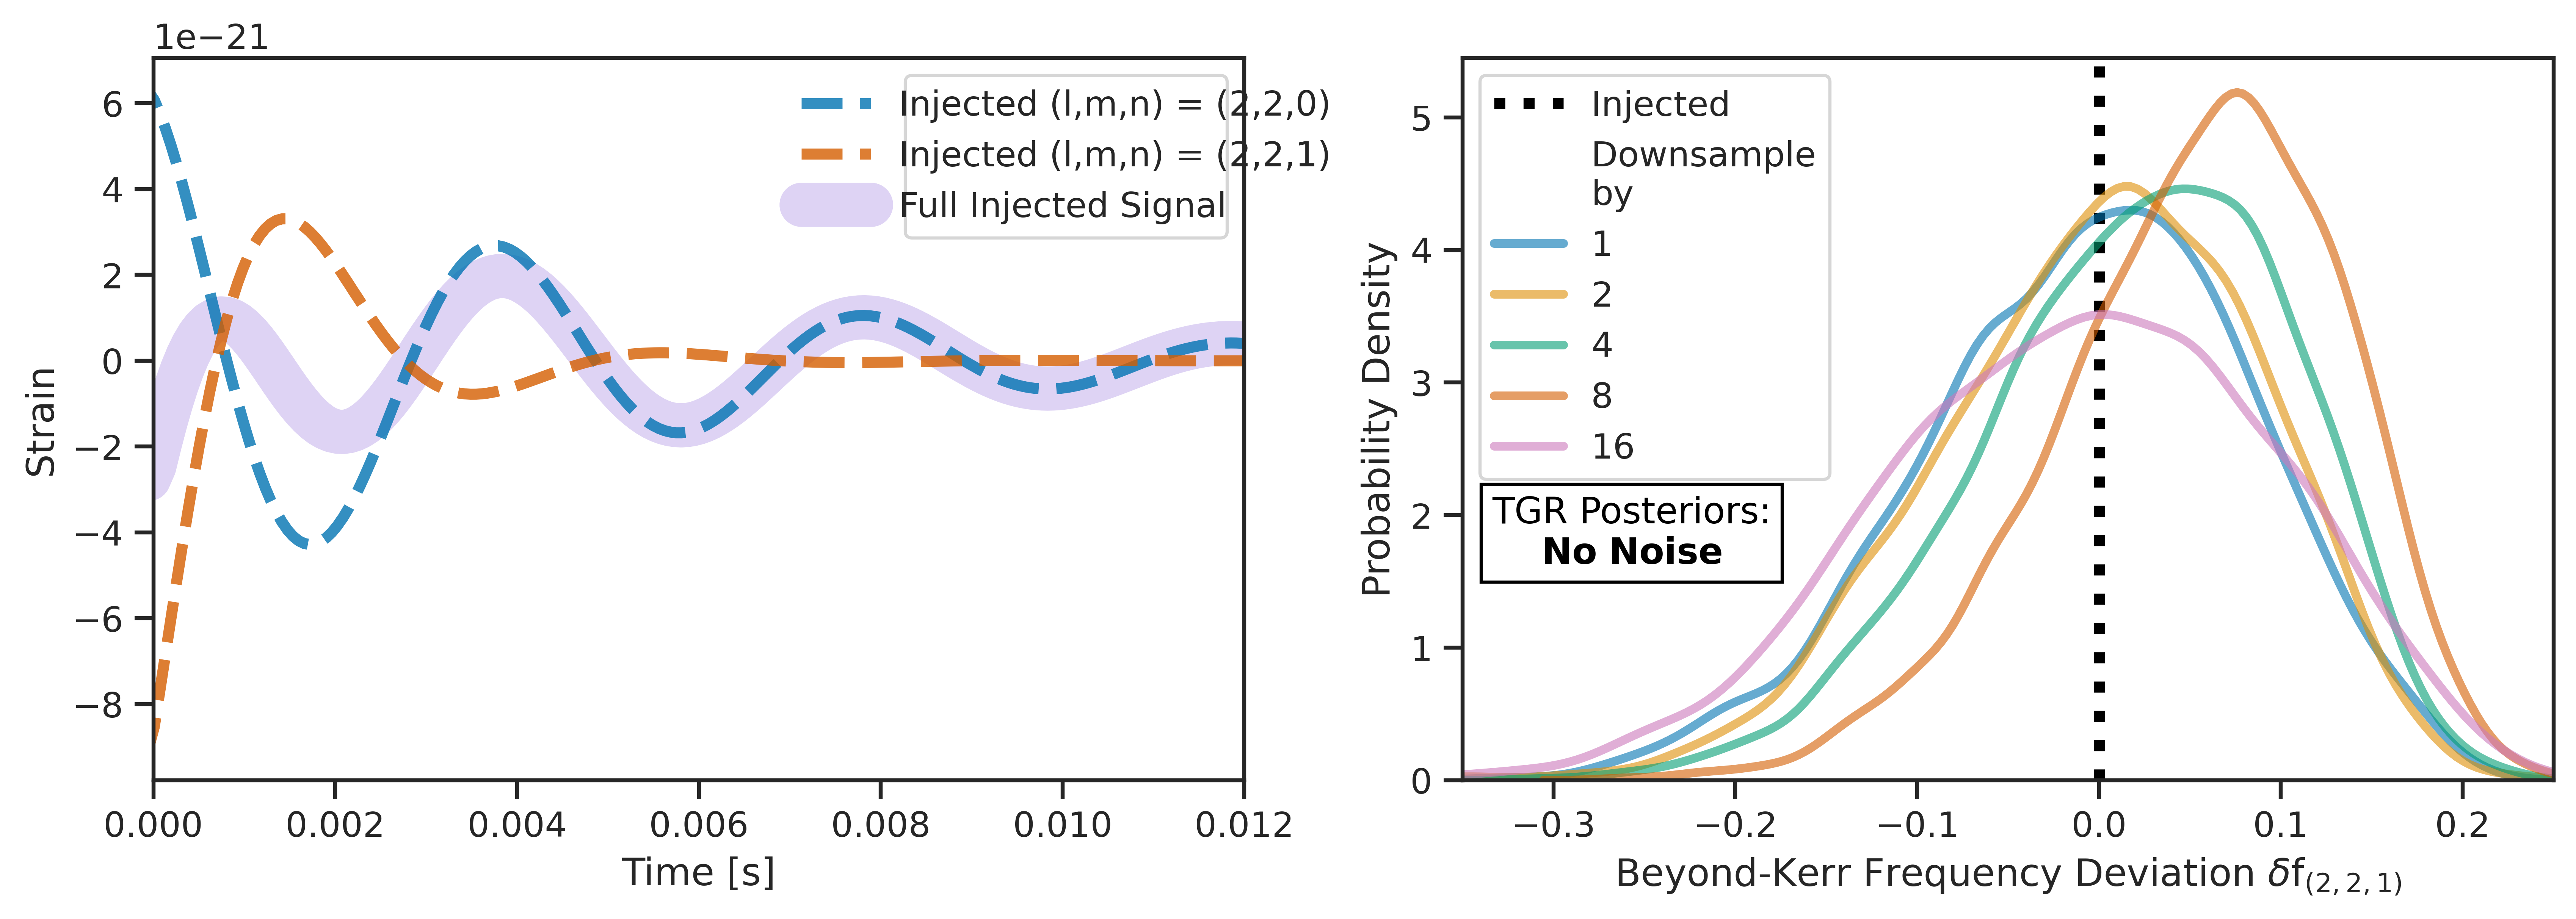

In [140]:
#plotting

fig, ax = plt.subplots(1,2, figsize = (2*fig_width,fig_height), dpi = 300)

cmap = sns.color_palette("colorblind")

small_lw = 2
med_lw = 2.75
big_lw = 3.5

quantile = .9

#Plotting for ax[0]

plot_ts = signal.index
plot_ts = plot_ts-plot_ts[0]-0.01

ax[0].plot(plot_ts,signal1.values, label = "Injected (l,m,n) = (2,2,0)",ls = "--",lw=big_lw,color=cmap[0],alpha=0.8)
ax[0].plot(plot_ts,signal2.values, label = "Injected (l,m,n) = (2,2,1)",ls = "--",lw=big_lw,color=cmap[3],alpha=0.8)
ax[0].plot(plot_ts,signal.values, label = "Full Injected Signal",ls = "-",lw=big_lw*4,color="mediumpurple",alpha=0.3,zorder=-10)


alpha = 0.33
ncols = 1

ax[0].set_xlim(0,0.012)
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Strain")

handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
leg = ax[0].legend(by_label.values(), by_label.keys(),title_fontsize=fs_label*0.8,ncols=ncols)
leg._legend_box.width=775


#Plotting for ax[1]

ax[1].axvline(0, ls = ":", zorder = -100, color="black", label = "Injected",lw=big_lw)

ax[1].axvline(0, zorder = 10, color=None, label = "Downsample\nby",lw=0)

kde_dict = {}
alpha = 0.6
c_count = 0
#lw = small_lw
lw = med_lw
for k,v in results_dict.items():
    sns.kdeplot(v.posterior.df.sel(mode = b'1,-2,2,2,1').values.flatten(),label = k, alpha = alpha, color=cmap[c_count],fill=False,lw=lw,ax=ax[1])
    c_count +=1
    
ax[1].set_xlim(-0.35,0.25)
#ax[1].set_ylim(0.45,2.3)
ax[1].set_xlabel("Beyond-Kerr Frequency Deviation "+r'$\delta$'+"f"+r'$_{(2,2,1)}$')
ax[1].set_ylabel("Probability Density")

ann_box_offset_x = 0.155
ann_box_offset_y = 0.3

ax[1].annotate("TGR Posteriors:\n" + r'$\bf{No~Noise}$', xy=[ax[1].get_xlim()[0]+(ax[1].get_xlim()[1]-ax[1].get_xlim()[0])*ann_box_offset_x, ax[1].get_ylim()[0]+(ax[1].get_ylim()[1]-ax[1].get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label*0.8, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))
leg = ax[1].legend(loc="upper left")

plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/TGR_bias",bbox_inches="tight")

## PSD Spike

### GW190521-like signal

#### Posteriors

In [129]:
results_dict = {}
results_dir = "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/single_ifo/"

for f in [x for x in sorted([y for y in os.listdir(results_dir) if ".csv" not in y and ".nc" in y and "GW190521" in y and "Lorentzianspike" in y],key = lambda x: float(x.split("dur")[1].split("s_")[0].replace("p",".")))]:
    print(f)
    results_dict[float(f.split("dur")[1].split("s_")[0].replace("p","."))] = az.from_netcdf(results_dir + f)
    
acfs_dict = {}
acfs_paths = ["/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/ACFs/ACF_GW190521_NOnoise_LIGOWelchPSDDigitalFilterNOSPIKE_fundamental_dur0p05_flow20p0_ds1.csv",
              "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/ACFs/ACF_GW190521_NOnoise_LIGOWelchPSDDigitalFilterLorentzianspike_fundamental_dur0p2_flow10_ds1.csv"]
              

acfs_dict["NOspike"] = ringdown.AutoCovariance(pd.read_csv(acfs_paths[0]).values.T[1],pd.read_csv(acfs_paths[0]).values.T[0])
acfs_dict["spike"] = ringdown.AutoCovariance(pd.read_csv(acfs_paths[1]).values.T[1],pd.read_csv(acfs_paths[1]).values.T[0])


GW190521_NOnoise_LIGOWelchPSDDitialFilterLorentzianspike_fundamental_ds1_sr4096_dur0p05s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
GW190521_NOnoise_LIGOWelchPSDDitialFilterLorentzianspike_fundamental_ds1_sr4096_dur0p1s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc
GW190521_NOnoise_LIGOWelchPSDDitialFilterLorentzianspike_fundamental_ds1_sr4096_dur0p2s_A1p2e-21_f67p489_ph5p34_tau0p0155_spikeA1p5e-45M67p489S0p05.nc


/tmp/ipykernel_4099626/2931805427.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(["{:.2f}".format(x) for x in xticks-xticks[0]])


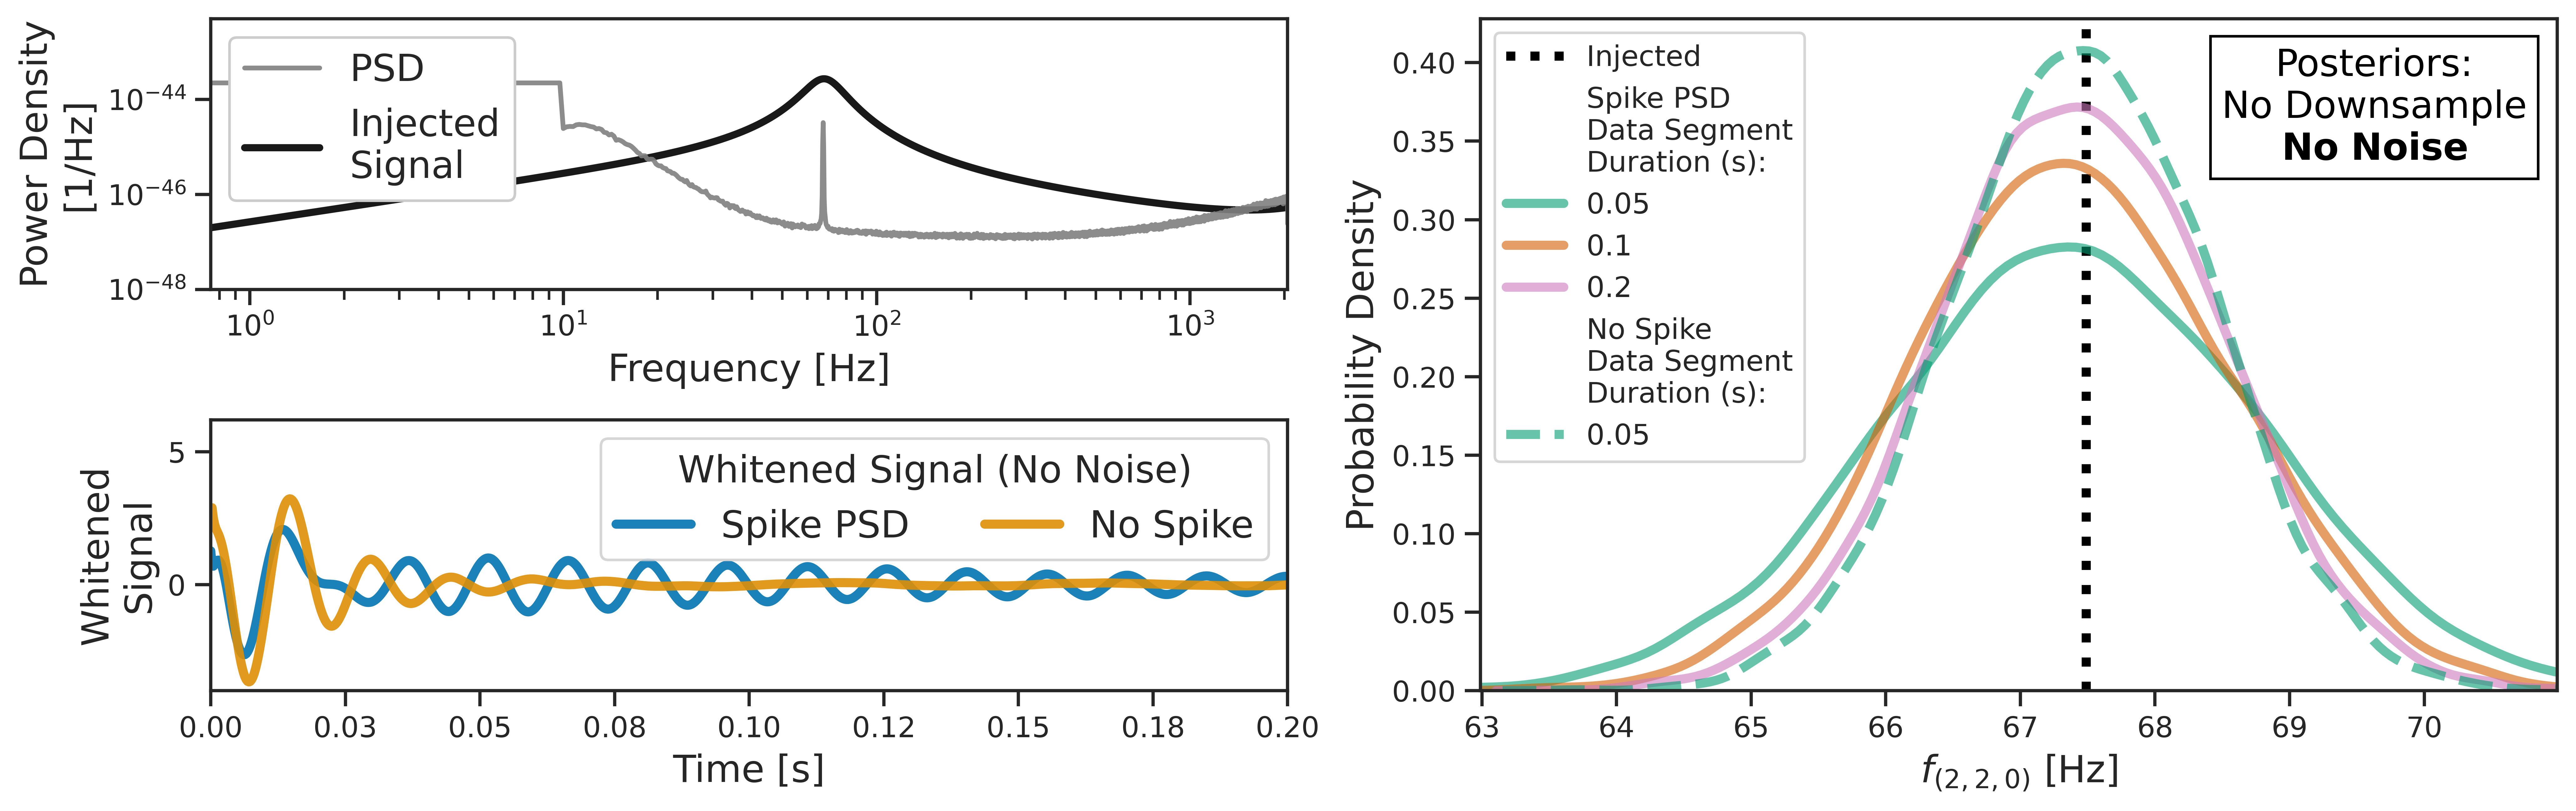

In [132]:
fig = plt.figure(constrained_layout=True, dpi = 300, figsize = (fig_width*2,fig_height))
gs_plot = gs(2, 2, figure=fig)

ax = []
ax1 = fig.add_subplot(gs_plot[0, 0])
ax2 = fig.add_subplot(gs_plot[1, 0])
ax3 = fig.add_subplot(gs_plot[:, 1])
ax.append(ax1)
ax.append(ax2)
ax.append(ax3)

cmap = sns.color_palette("colorblind")
#cmap = sns.color_palette("mako",n_colors=len(results_dict))

small_lw = 2
med_lw = 2.75
big_lw = 3.5

#ax[0]

# PSD parameters

#data parameters
sample_rate = 2**12
ds = 1
duration = 128
noise_td = generate_noise(sr=sample_rate/ds, rtrn_psd=False, lalpsd = True)
psd_analysis = acfs_dict["spike"].to_psd()
times = noise_td.index
delta_t = 1/sample_rate
t0 = duration/2

f_qnm = 67.489
A = 1.2e-21
tau_qnm = 0.0155
phase_qnm = 5.34 # radians

signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

#number of samples per chain
draws = 2000

acf_analysis = acfs_dict["spike"]
        
c_count = 0
lw = med_lw
alpha = 0.9

ann_slope = -3.2 #slope for producing straight lines on loglog plot
b = np.log(5e-47)-ann_slope*np.log(8192) #y intercept for producing straight lines on loglog plot

ax[0].plot(psd_analysis.index, psd_analysis.values, color = "grey", lw = lw*2/3, ls = "-", zorder = 1, alpha = alpha,label = "PSD")
freqs_analysis = np.fft.rfftfreq(len(noise_td[t0:]), delta_t)
signal_FT = np.fft.rfft(signal[t0:].values)/sample_rate*2 # multiply by 2 to get power right
sig_power = ringdown.FrequencySeries(freqs_analysis*(signal_FT.real**2+signal_FT.imag**2),freqs_analysis)
ax[0].plot(sig_power, color = "black", lw=lw, zorder = -100,label = "Injected\nSignal",alpha=alpha)
c_count += 1

ax[0].legend(loc="upper left",fontsize=fs_label, framealpha=1)
ax[0].set_ylim(1e-48, 5e-43)
ax[0].set_xlim(0.75,sample_rate/2)
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_xlabel('Frequency [Hz]', fontsize = fs_label)
ax[0].set_ylabel("Power Density\n[1/Hz]", fontsize = fs_label)
    
#ax[1]
alpha = 0.9
dur_whiten = 0.4
whtnd_sig = acf_analysis[0:dur_whiten].whiten(signal[t0:t0+dur_whiten]) #Spike whitening
ax[1].plot(whtnd_sig,label="Spike PSD",color=cmap[0],alpha=alpha,lw=big_lw)

acf_analysis2 = acfs_dict["NOspike"]
whtnd_sig2 = acf_analysis2[0:dur_whiten].whiten(signal[t0:t0+dur_whiten])
ax[1].plot(whtnd_sig2,label="No Spike",color=cmap[1],alpha=alpha,lw=big_lw) #No spike whitening


xmax = 0.2
ax[1].set_xlim(t0,t0+xmax)
ax[1].set_ylim(-4,6.2)

xticks = ax[1].get_xticks()
ax[1].set_xticklabels(["{:.2f}".format(x) for x in xticks-xticks[0]])

ax[1].set_xlabel('Time [s]',fontsize=fs_label)
ax[1].set_ylabel("Whitened\nSignal",fontsize=fs_label)

leg = ax[1].legend(loc="upper right",ncol=2,fontsize=fs_label)
leg.set_title(title="Whitened Signal (No Noise)",prop = {'size':fs_label})
#legend_title_left(leg)

#ax[2]

alpha = 0.6
c_count = 2
lw = big_lw

ax[2].axvline(f_qnm, ls = ":", zorder = -10, color="black", label = "Injected", lw=big_lw)
ax[2].axvline(f_qnm,label = "Spike PSD\nData Segment\nDuration (s):",lw = 0, color= None)

for k,v in results_dict.items():
    #if k > 0.05:
    #    alpha = 0.95
    #    lw = big_lw
    if type(k) is not str:
        sns.kdeplot(v.posterior.f.values.flatten(),label =k, linewidth=lw, alpha = alpha, ax = ax[2],color=cmap[c_count])
        c_count +=1
    else:
        sns.kdeplot(v.posterior.f.values.flatten(),label =k, linewidth=lw, alpha = alpha, ls="--", ax = ax[2],color="grey")
        
ax[2].axvline(f_qnm,label = "No Spike\nData Segment\nDuration (s):",lw = 0, color= None)
no_spike_result = az.from_netcdf("/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/single_ifo/GW190521_NOnoise_LIGOWelchPSDDitialFilter_fundamental_ds1_sr4096_dur0p05s_A1p2e-21_f67p489_ph5p34_tau0p0155.nc")
sns.kdeplot(no_spike_result.posterior.f.values.flatten(),label = 0.05, linewidth=lw, linestyle = "--", alpha = alpha, ax = ax[2],color=cmap[2])

ax[2].set_xlim(f_qnm-4.5,f_qnm+3.5)
ax[2].legend(loc = "upper left")
ax[2].set_xlabel(r'$f_{(2,2,0)}$' + " [Hz]", fontsize = fs_label)
ax[2].set_ylabel("Probability Density",fontsize = fs_label)
ann_box_offset_x = 0.83
ann_box_offset_y = 0.79
ax[2].annotate("Posteriors:\nNo Downsample\n"+r'$\bf{No~Noise}$', xy=[ax[2].get_xlim()[0]+(ax[2].get_xlim()[1]-ax[2].get_xlim()[0])*ann_box_offset_x, ax[2].get_ylim()[0]+(ax[2].get_ylim()[1]-ax[2].get_ylim()[0])*ann_box_offset_y], color="black", fontsize = fs_label, ha = "center", bbox=dict(boxstyle="square", fc = "white", ec="black"))

plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/PSDspike_bias",bbox_inches="tight")

#### Cumulative SNR

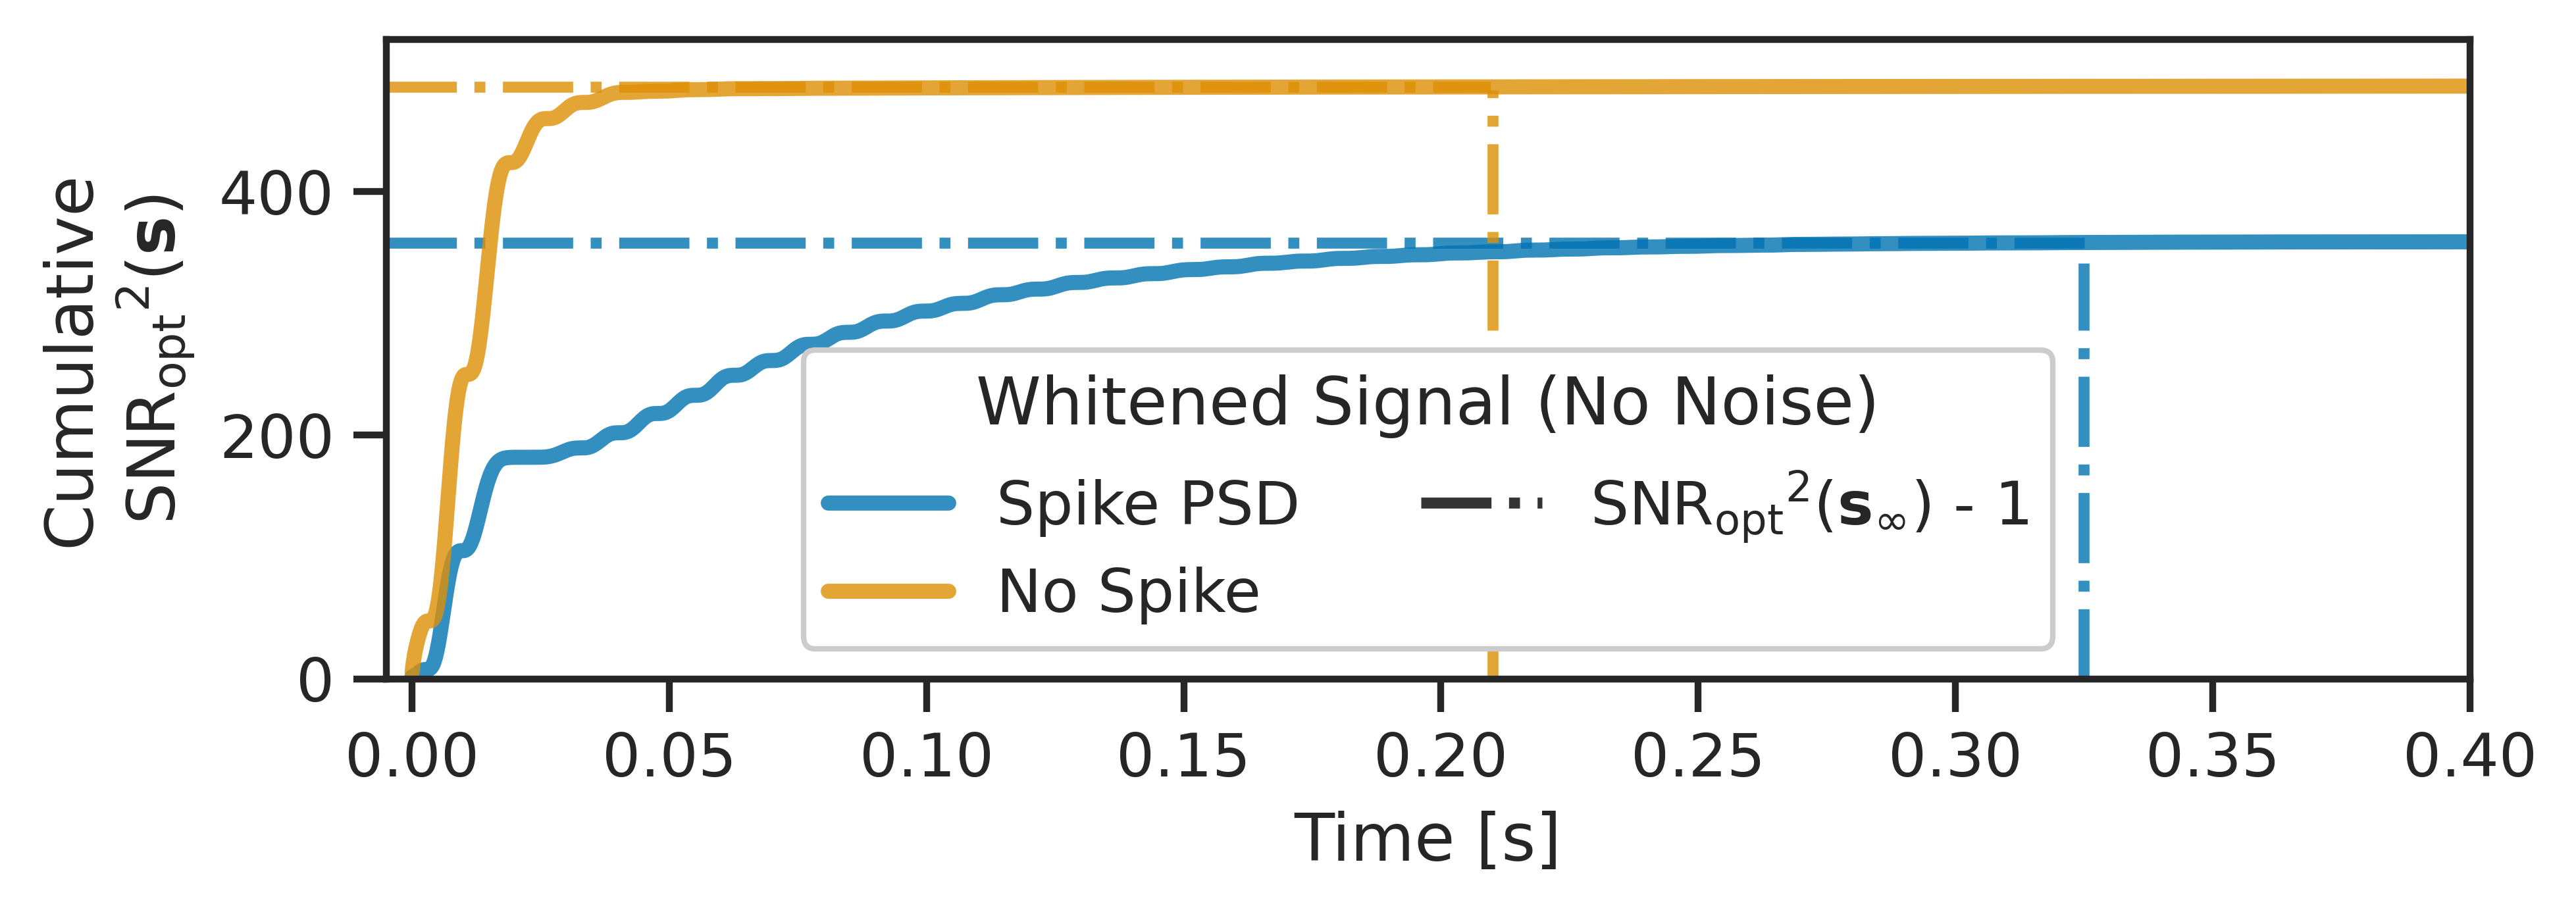

In [93]:
fig, ax = plt.subplots(1,1, figsize = (fig_width,fig_height/2), dpi = 300)

dur_whiten = 0.6

f_qnm = 67.489
A = 1.2e-21
tau_qnm = 0.0155
phase_qnm = 5.34 # radians

duration = 128
noise_td_generic = generate_noise(lalpsd = True, dur=duration,sr=2**12)

times = noise_td_generic.index
t0 = duration/2

acfs_dict = {}
acfs_paths = ["/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/ACFs/ACF_GW190521_NOnoise_LIGOWelchPSDDigitalFilterNOSPIKE_fundamental_dur0p05_flow20p0_ds1.csv",
              "/mnt/home/hsiegel/ceph/conditioning_data_studies/results/FINAL/ACFs/ACF_GW190521_NOnoise_LIGOWelchPSDDigitalFilterLorentzianspike_fundamental_dur0p2_flow10_ds1.csv"]
              

acfs_dict["NOspike"] = ringdown.AutoCovariance(pd.read_csv(acfs_paths[0]).values.T[1],pd.read_csv(acfs_paths[0]).values.T[0])
acfs_dict["spike"] = ringdown.AutoCovariance(pd.read_csv(acfs_paths[1]).values.T[1],pd.read_csv(acfs_paths[1]).values.T[0])

signal = damped_sinusoid(A=A, f=f_qnm, gamma=1/tau_qnm, phase=phase_qnm, times=times[int(len(times)/2):])

acf_analysis = acfs_dict["spike"]
whtnd_sig = acf_analysis[0:dur_whiten].whiten(signal[t0:t0+dur_whiten]) #Spike whitening

acf_analysis2 = acfs_dict["NOspike"]
whtnd_sig2 = acf_analysis2[0:dur_whiten].whiten(signal[t0:t0+dur_whiten])

cum_snrs = np.cumsum(np.square(whtnd_sig))
cum_snrs2 = np.cumsum(np.square(whtnd_sig2))

c_map = sns.color_palette("colorblind")
alpha = 0.8

plt.axhline(cum_snrs.values[-1]-1,ls="-.",lw=small_lw,color = c_map[0],alpha=alpha,xmin=0,xmax=0.82)
plt.axvline(0.325,ls="-.",lw=small_lw,color = c_map[0],alpha=alpha,ymin=0,ymax=0.65)

plt.axhline(cum_snrs2.values[-1]-1,ls="-.",lw=small_lw,color = c_map[1],alpha=alpha,xmin=0,xmax=0.53)
plt.axvline(0.21,ls="-.",lw=small_lw,color = c_map[1],alpha=alpha,ymin=0,ymax=0.92)

plt.plot(whtnd_sig.index-64,cum_snrs,label="Spike PSD",lw=med_lw,color = c_map[0],alpha=alpha)
plt.plot(whtnd_sig2.index-64,cum_snrs2,label="No Spike",lw=med_lw,color = c_map[1],alpha=alpha)

plt.axvline(-1,ls="-.",lw=small_lw,color = "black",alpha=alpha,label="SNR" +r'$_\mathregular{opt}$'+r'$^2$'+r'($\mathbf{s}_\infty$)' +" - 1")

plt.ylim(0,525)

plt.ylabel("Cumulative\nSNR"+r'$_\mathregular{opt}$'+r'$^2$'+r'($\mathbf{s}$)')
plt.xlabel("Time [s]")

plt.legend(title="Whitened Signal (No Noise)",loc="lower center",ncols=2,framealpha=1)

plt.xlim(-0.005,0.4)

plt.savefig("/mnt/home/hsiegel/ceph/conditioning_data_studies/figures/cumulativeSNR_spike",bbox_inches="tight")

In [415]:
np.argmin((-cum_snrs.values+cum_snrs.values[-1]-1)**2)

1331

In [445]:
cum_snrs.index[1331]

64.324951171875

In [425]:
np.argmin((-cum_snrs2.values+cum_snrs2.values[-1]-1)**2)

875

In [430]:
cum_snrs.index[875]

64.213623046875

(0.0, 2.0)

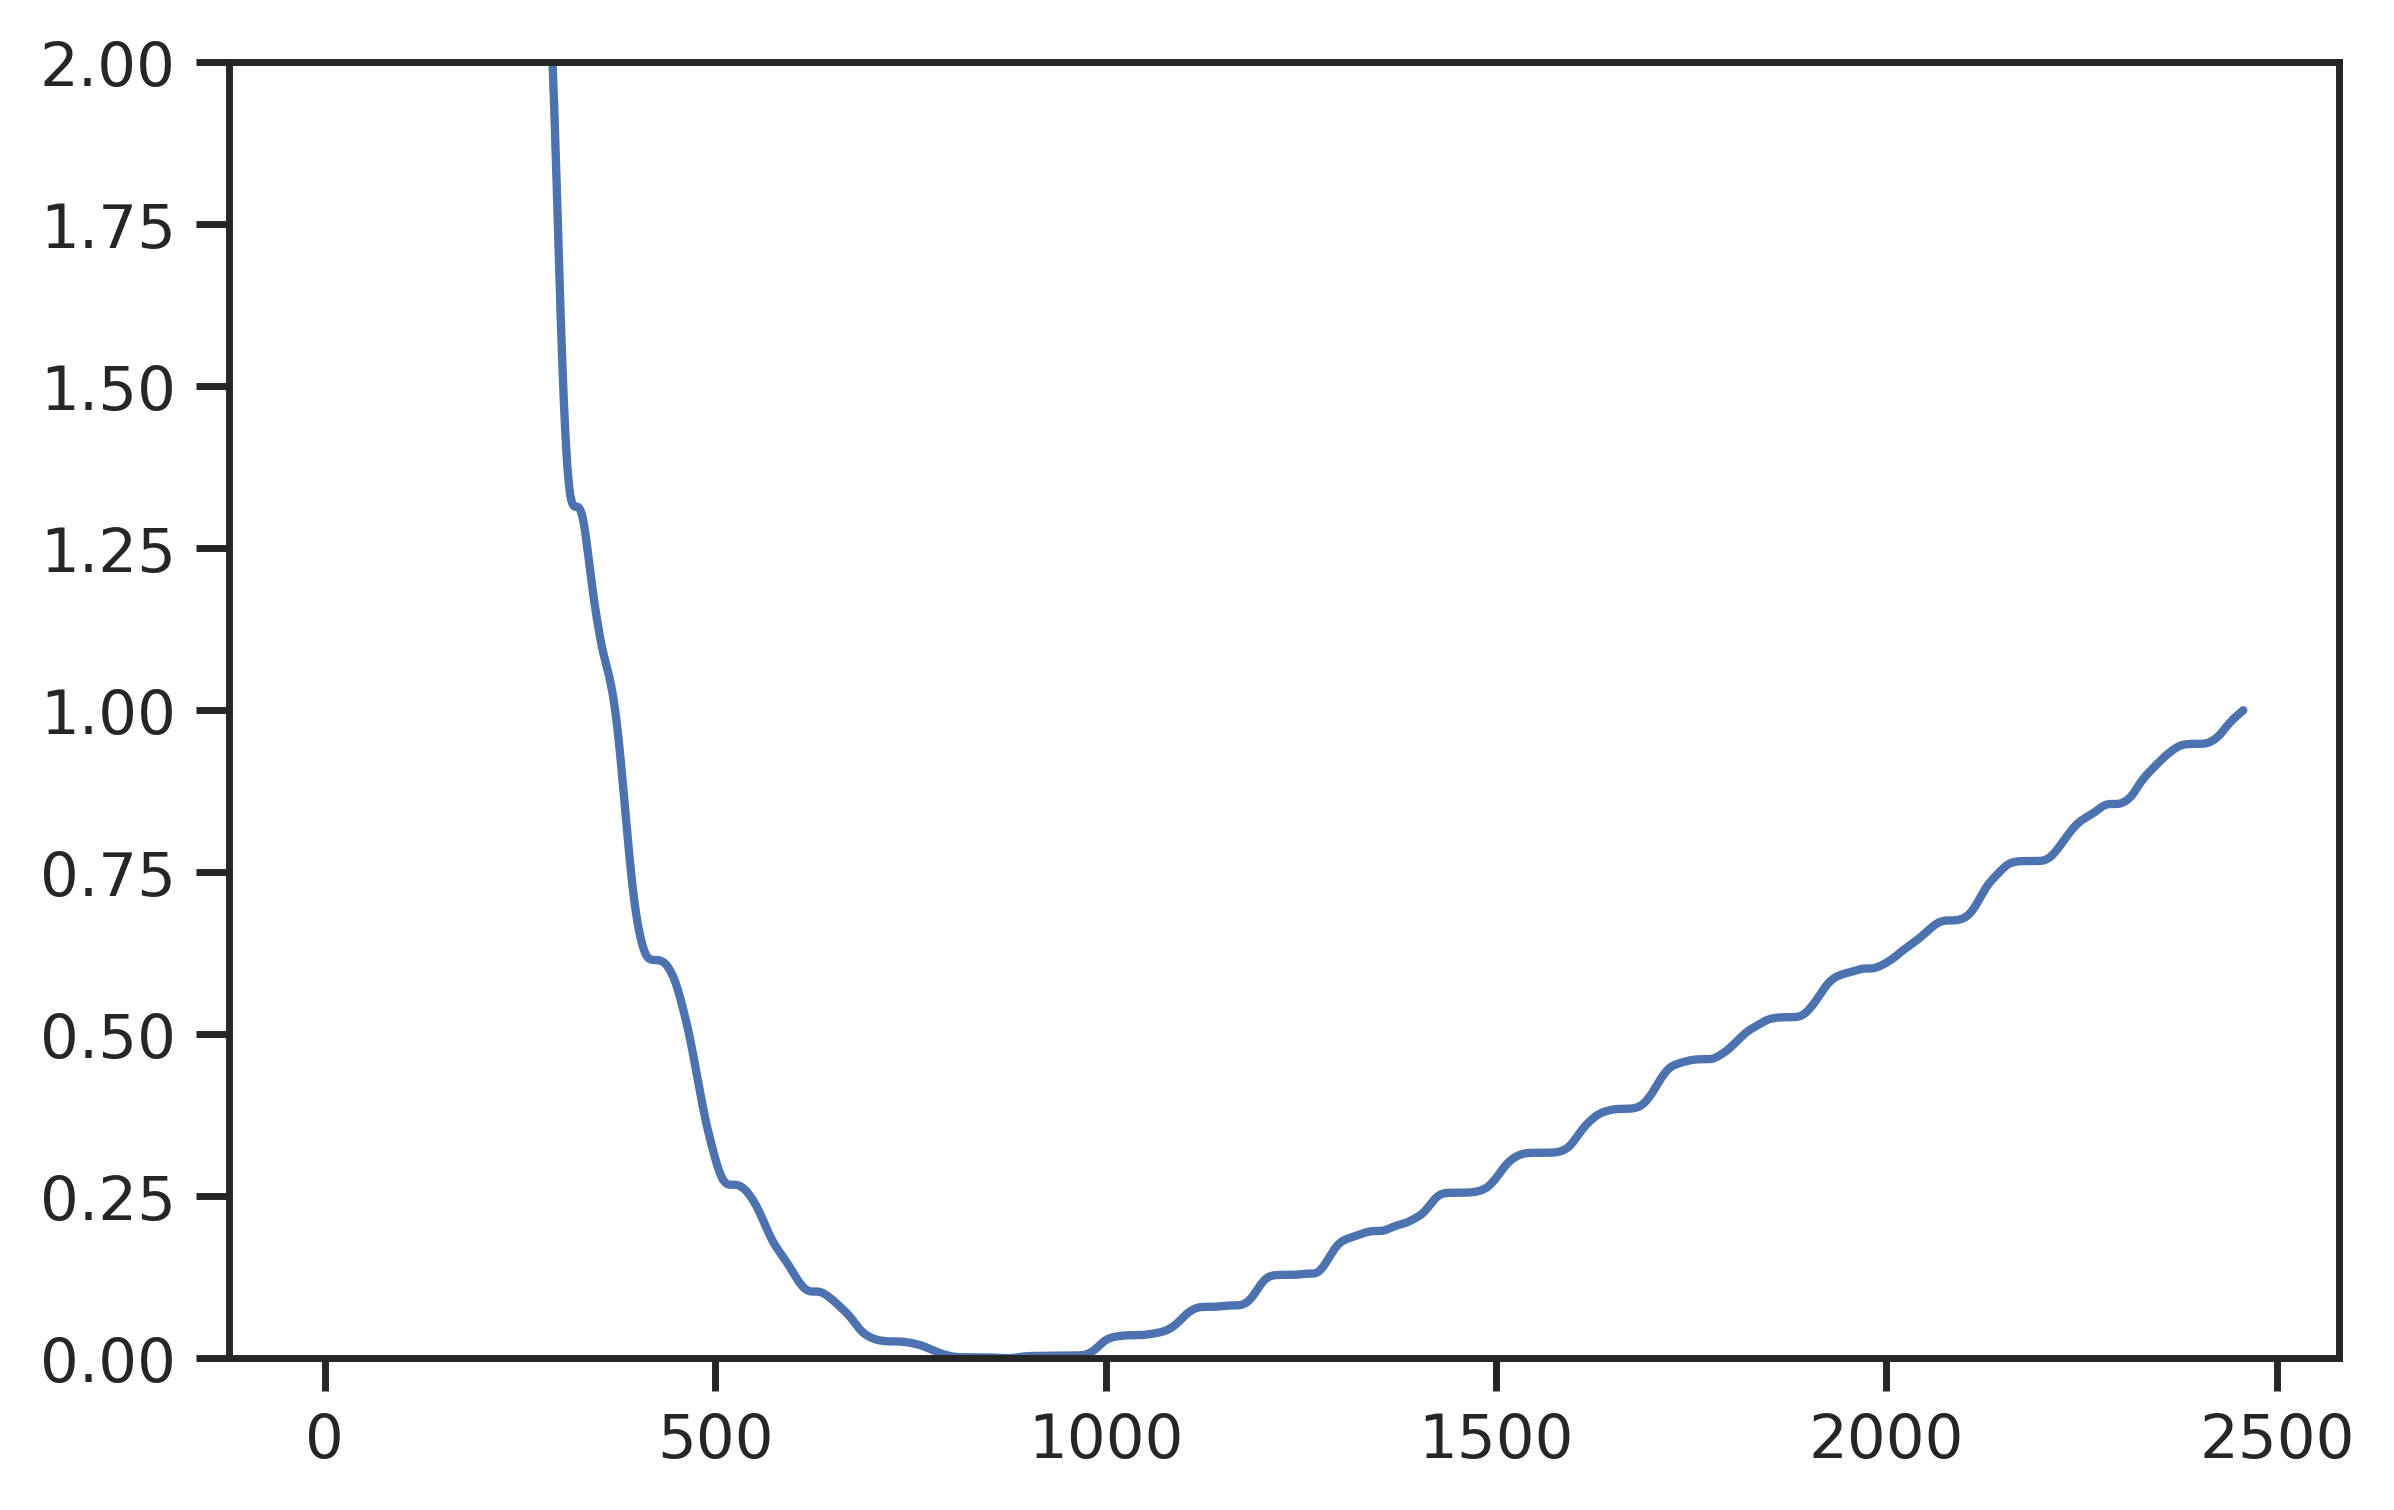

In [446]:
plt.plot((-cum_snrs2.values+cum_snrs2.values[-1]-1)**2)
plt.ylim(0,2)

(0.0, 1.0)

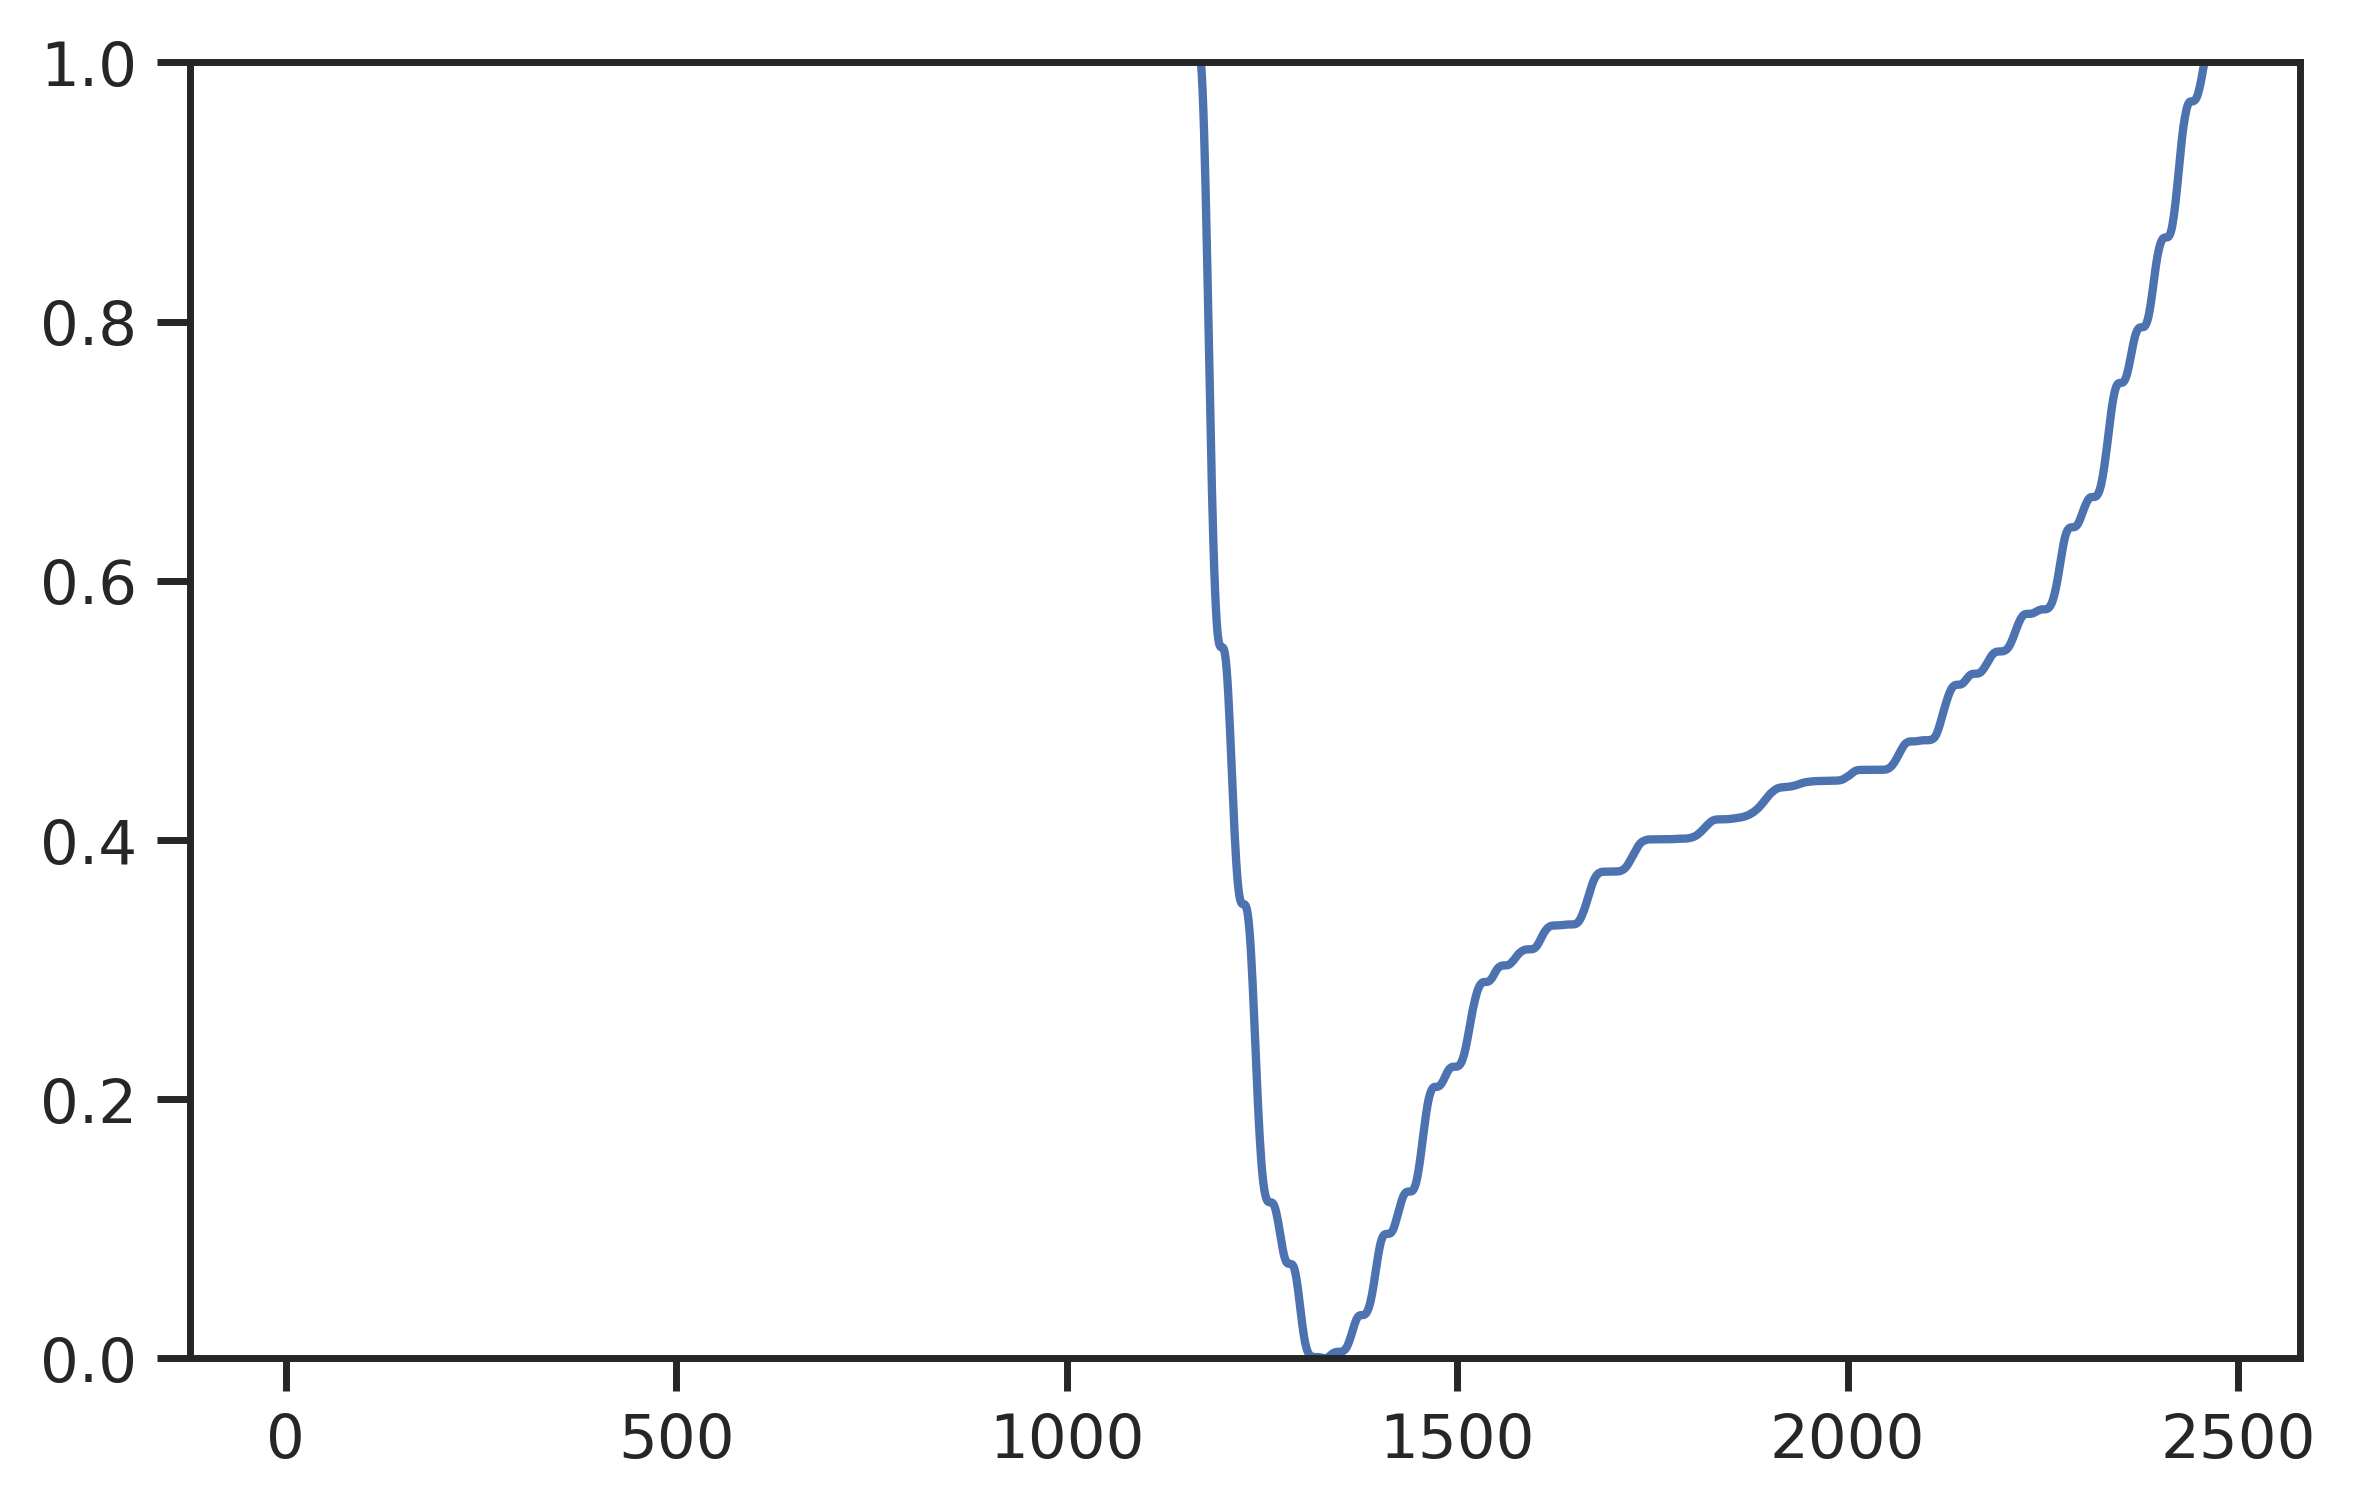

In [424]:
plt.plot((-cum_snrs.values+cum_snrs.values[-1]-1)**2)
plt.ylim(0,1)